In [1]:
# Load modules

import pickle
import torch
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
import sys
import os
sys.path.append('..')
from types import SimpleNamespace
from field_of_junctions import FieldOfJunctions
import nbimporter

from torchsummary import summary

from Dataset_Maker_Lines import make_random_line_set, make_grey_transform

# %load_ext autoreload
# %reload_ext autoreload

In [2]:
dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [27]:
# num_samples = 100
# R = 64
    
# # make_random_line_set(num_samples,R,dev,zero_center,delta=.25,eta=0.005)
# dists,wedges,boundaries,params = make_random_line_set(num_samples,R,dev,1)

# # make_grey_transform(num_images,dev,opt=0)
# grey_transform = make_grey_transform(num_samples,dev)

# wedges_grey = (wedges[:,:2,:,:,:,:]*grey_transform).sum(1).squeeze(1)

In [10]:
class LineDataset(torch.utils.data.Dataset):
    """ Dataset with support of transforms.
    """

    def __init__(self, images, params, boundaries, wedges, transform=None):
        self.images = images
        self.params = params
        self.boundaries = boundaries
        self.wedges = wedges
        self.transform = transform

    def __getitem__(self, index):
        
        image = self.images[index]
        wedge = self.wedges[index]

        if self.transform:
            image = self.transform(image)
            
        param = self.params[index].squeeze()
        boundary = self.boundaries[index]
        
        return image, param, boundary, wedge

    def __len__(self):
        return len(self.images)

In [29]:
# Load dataset 

data_folder = 'foj_data/grayscale_lines/'

with open(data_folder + 'line_data_64_100_grey_bicolor_centered.pkl','rb') as f:
    data = pickle.load(f)

# wedges = data['wedges']
wedges_grey = data['wedges_grey']
params = data['params']
boundaries = data['boundaries']
wedges = data['wedges']

In [30]:
print(wedges_grey.shape)
print(params.shape)
print(boundaries.shape)
print(wedges.shape)

line_data = LineDataset(wedges_grey, params, boundaries, wedges)#, transform=trainTransform)
data_size = len(line_data)

print(data_size)

train_proportion = .85
# Split dataset into training and testing
train_dataset, test_dataset = torch.utils.data.random_split(line_data, [int(data_size*train_proportion), int(data_size*(1-train_proportion))], generator=torch.Generator().manual_seed(42))

# Create loaders for the training and testing data
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False) #len(test_dataset)


torch.Size([100, 1, 64, 64])
torch.Size([100, 3, 1, 1])
torch.Size([100, 1, 1, 64, 64])
torch.Size([100, 3, 1, 1, 64, 64])
100


In [31]:
class lineNet(nn.Module):

    def __init__(self):
        super().__init__()
                
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3)
        self.conv2 = nn.Conv2d(64, 1, kernel_size=3)
        self.fc = nn.LazyLinear(2)
    
    def forward(self, x):

        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = x.view(x.shape[0],-1)
    
        x = self.fc(x)
         
        # We're defining
        # a = - sin(theta)
        # b = cos(theta)
        # c = -cy*cos(theta)+cx*sin(theta)
        # Hence, we want to normalize the vector by 1/sqrt(a^2 + b^2)
        norm_factor = (torch.norm(x,p=2,dim=1)).unsqueeze(1)        
        out = x/(norm_factor)#+eps)
#         print('Output shape=',x.shape)
        
        return out
    
model = lineNet()
model = model.to(dev)
summary(model, input_size=[(1, 64, 64)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 62, 62]             640
            Conv2d-2            [-1, 1, 60, 60]             577
            Linear-3                    [-1, 2]           7,202
Total params: 8,419
Trainable params: 8,419
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/backward pass size (MB): 1.90
Params size (MB): 0.03
Estimated Total Size (MB): 1.95
----------------------------------------------------------------


In [32]:
# Now let's train the initial network 

model = lineNet()
model = model.to(dev)

model.train();

optimizer = torch.optim.Adam(model.parameters(),lr=.00001) #8,419 training parameters

n_epochs = 700

mse_loss = nn.MSELoss()
ce_loss = nn.CrossEntropyLoss()

for epoch in range(0,n_epochs):  # loop over the dataset multiple times

    if epoch == 0:
        train_loss_over_time = [] # to track the loss as the network trains
        test_loss_over_time = []
        
    running_loss = 0
    num_batches = 0
    
    for batch_i, data in enumerate(train_loader):
        
        # get the input images and their corresponding labels
        num_batches += 1

        inputs, output_gt, _, _ = data
        inputs, output_gt = inputs.to(dev), output_gt.to(dev)
        
        # zero the parameter (weight) gradients
        optimizer.zero_grad()
        
        # forward pass to get outputs
        output_line_params = model(inputs)

        # make the ground truth
        gt_line_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0])),dim=1)
        
        # calculate the loss
#         print(output_line_params[:,:,0,50])
        
        loss = mse_loss(output_line_params,gt_line_params)
        
        # backward pass to calculate the parameter gradients
        loss.backward()

        # update the parameters
        optimizer.step()

        # to convert loss into a scalar and add it to running_loss, we use .item()
        running_loss += loss.item()
      

    # Calculate test data loss after each epoch
    with torch.no_grad():
        test_loss = 0
        num_batches_test = 0
        for batch_i, data in enumerate(test_loader):
            num_batches_test += 1

            # Add code here
            inputs, output_gt, _, _ = data
            inputs, output_gt = inputs.to(dev), output_gt.to(dev)


            # zero the parameter (weight) gradients
            optimizer.zero_grad()

            # forward pass to get outputs
            output_line_params = model(inputs)

            # make the ground truth
            gt_line_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0])),dim=1)

            # calculate the loss
    #         print(output_line_params[:,:,0,50])

            loss = mse_loss(output_line_params,gt_line_params)
            
            test_loss += loss
                    
        test_loss_over_time.append(test_loss/num_batches_test)


    # Calculate model loss:
    avg_loss = running_loss/num_batches
    train_loss_over_time.append(avg_loss)
    
#     print('Epoch: {}, Avg. Train Loss: {},'.format(epoch + 1, train_loss_over_time[-1]))


    print('Epoch: {}, Avg. Train Loss: {}, Avg. Test Loss: {}'.format(epoch + 1, train_loss_over_time[-1], test_loss_over_time[-1]))
    
print('Finished Training')

Epoch: 1, Avg. Train Loss: 0.566504335665548, Avg. Test Loss: 0.6136671900749207
Epoch: 2, Avg. Train Loss: 0.19136037635674738, Avg. Test Loss: 0.12330912053585052
Epoch: 3, Avg. Train Loss: 0.05528871321831128, Avg. Test Loss: 0.024192949756979942
Epoch: 4, Avg. Train Loss: 0.019068437478448257, Avg. Test Loss: 0.010748140513896942
Epoch: 5, Avg. Train Loss: 0.013787026510202421, Avg. Test Loss: 0.008540378883481026
Epoch: 6, Avg. Train Loss: 0.011839056952319993, Avg. Test Loss: 0.0071611604653298855
Epoch: 7, Avg. Train Loss: 0.0098732655197222, Avg. Test Loss: 0.005974114872515202
Epoch: 8, Avg. Train Loss: 0.008409045650190742, Avg. Test Loss: 0.0048181745223701
Epoch: 9, Avg. Train Loss: 0.0071988980918801775, Avg. Test Loss: 0.0038153643254190683
Epoch: 10, Avg. Train Loss: 0.00629584698957548, Avg. Test Loss: 0.0037481444887816906
Epoch: 11, Avg. Train Loss: 0.005654909862802443, Avg. Test Loss: 0.0029640861321240664
Epoch: 12, Avg. Train Loss: 0.004886128536035732, Avg. Test 

Epoch: 94, Avg. Train Loss: 0.00016846628236894437, Avg. Test Loss: 0.00027298906934447587
Epoch: 95, Avg. Train Loss: 0.00011357378185182069, Avg. Test Loss: 0.00027879071421921253
Epoch: 96, Avg. Train Loss: 0.00015872926130591606, Avg. Test Loss: 0.0004118606448173523
Epoch: 97, Avg. Train Loss: 0.00012039173530231127, Avg. Test Loss: 0.0003875039692502469
Epoch: 98, Avg. Train Loss: 0.00011649585854430832, Avg. Test Loss: 0.0002662621554918587
Epoch: 99, Avg. Train Loss: 0.00012392273604266326, Avg. Test Loss: 0.0003143266658298671
Epoch: 100, Avg. Train Loss: 0.0001481010656512653, Avg. Test Loss: 0.0003500116290524602
Epoch: 101, Avg. Train Loss: 0.00017576649262393323, Avg. Test Loss: 0.00026819398044608533
Epoch: 102, Avg. Train Loss: 0.00011119938148219851, Avg. Test Loss: 0.00047897655167616904
Epoch: 103, Avg. Train Loss: 0.00010791911337632347, Avg. Test Loss: 0.0002452436601743102
Epoch: 104, Avg. Train Loss: 0.00011394403067845109, Avg. Test Loss: 0.00022900202020537108
E

Epoch: 186, Avg. Train Loss: 5.6946756404506555e-05, Avg. Test Loss: 0.0001405934162903577
Epoch: 187, Avg. Train Loss: 2.692726392320106e-05, Avg. Test Loss: 0.00017825716349761933
Epoch: 188, Avg. Train Loss: 2.10835904690294e-05, Avg. Test Loss: 0.0001360726309940219
Epoch: 189, Avg. Train Loss: 1.781570231705299e-05, Avg. Test Loss: 0.0001521860103821382
Epoch: 190, Avg. Train Loss: 1.6416920839886185e-05, Avg. Test Loss: 0.00011628615902736783
Epoch: 191, Avg. Train Loss: 1.3616152127665975e-05, Avg. Test Loss: 0.00013407145161181688
Epoch: 192, Avg. Train Loss: 2.639912177882476e-05, Avg. Test Loss: 0.00015303656982723624
Epoch: 193, Avg. Train Loss: 4.079870070502021e-05, Avg. Test Loss: 0.00018370883481111377
Epoch: 194, Avg. Train Loss: 3.1530029392189865e-05, Avg. Test Loss: 0.00016826011415105313
Epoch: 195, Avg. Train Loss: 1.800977947484337e-05, Avg. Test Loss: 0.00014597516565117985
Epoch: 196, Avg. Train Loss: 4.334193107723231e-05, Avg. Test Loss: 9.764503920450807e-05


Epoch: 276, Avg. Train Loss: 2.2177443272136337e-05, Avg. Test Loss: 9.562660125084221e-05
Epoch: 277, Avg. Train Loss: 1.7839169633092427e-05, Avg. Test Loss: 8.737108146306127e-05
Epoch: 278, Avg. Train Loss: 7.047138191955159e-06, Avg. Test Loss: 0.00012989717652089894
Epoch: 279, Avg. Train Loss: 2.2960137253266895e-05, Avg. Test Loss: 0.0001595206995261833
Epoch: 280, Avg. Train Loss: 1.681532905262315e-05, Avg. Test Loss: 0.00010256589303025976
Epoch: 281, Avg. Train Loss: 9.46062994600878e-06, Avg. Test Loss: 7.790613744873554e-05
Epoch: 282, Avg. Train Loss: 1.5778153059642364e-05, Avg. Test Loss: 8.647789945825934e-05
Epoch: 283, Avg. Train Loss: 3.176272415708451e-05, Avg. Test Loss: 9.220163337886333e-05
Epoch: 284, Avg. Train Loss: 4.498746270279659e-05, Avg. Test Loss: 0.0001224352599820122
Epoch: 285, Avg. Train Loss: 3.434921543796634e-05, Avg. Test Loss: 0.00018697988707572222
Epoch: 286, Avg. Train Loss: 2.4473674531431383e-05, Avg. Test Loss: 8.727422391530126e-05
Epo

Epoch: 368, Avg. Train Loss: 4.292224199071584e-06, Avg. Test Loss: 7.669867773074657e-05
Epoch: 369, Avg. Train Loss: 2.173408503010588e-06, Avg. Test Loss: 7.641971751581877e-05
Epoch: 370, Avg. Train Loss: 4.238847143543096e-06, Avg. Test Loss: 7.609707972733304e-05
Epoch: 371, Avg. Train Loss: 9.738040326000694e-06, Avg. Test Loss: 9.007338667288423e-05
Epoch: 372, Avg. Train Loss: 9.381467503539611e-06, Avg. Test Loss: 5.9985668485751376e-05
Epoch: 373, Avg. Train Loss: 7.121725852719235e-06, Avg. Test Loss: 7.219806866487488e-05
Epoch: 374, Avg. Train Loss: 3.6320723143270245e-05, Avg. Test Loss: 0.0001681303110672161
Epoch: 375, Avg. Train Loss: 5.969871429609827e-05, Avg. Test Loss: 0.00011543220898602158
Epoch: 376, Avg. Train Loss: 2.5733191571199106e-05, Avg. Test Loss: 8.963314030552283e-05
Epoch: 377, Avg. Train Loss: 9.11600409680054e-06, Avg. Test Loss: 7.806454959791154e-05
Epoch: 378, Avg. Train Loss: 4.235141453503304e-06, Avg. Test Loss: 6.646030669799075e-05
Epoch: 

Epoch: 460, Avg. Train Loss: 4.3034793934637605e-05, Avg. Test Loss: 0.00012744299601763487
Epoch: 461, Avg. Train Loss: 2.2694675954075946e-05, Avg. Test Loss: 8.5991203377489e-05
Epoch: 462, Avg. Train Loss: 1.8673058130764026e-05, Avg. Test Loss: 7.016423478489742e-05
Epoch: 463, Avg. Train Loss: 3.6425620935688547e-06, Avg. Test Loss: 6.140381447039545e-05
Epoch: 464, Avg. Train Loss: 2.50480506467496e-06, Avg. Test Loss: 6.488736835308373e-05
Epoch: 465, Avg. Train Loss: 1.5984192881395429e-06, Avg. Test Loss: 6.324520654743537e-05
Epoch: 466, Avg. Train Loss: 1.373800150580372e-06, Avg. Test Loss: 5.6408141972497106e-05
Epoch: 467, Avg. Train Loss: 3.232816157094267e-06, Avg. Test Loss: 5.542916551348753e-05
Epoch: 468, Avg. Train Loss: 3.6820084409599723e-06, Avg. Test Loss: 5.199150473345071e-05
Epoch: 469, Avg. Train Loss: 5.07990967815175e-06, Avg. Test Loss: 7.549960719188675e-05
Epoch: 470, Avg. Train Loss: 6.4709228051305996e-06, Avg. Test Loss: 6.0805246903328225e-05
Epoc

Epoch: 552, Avg. Train Loss: 7.809534519070633e-06, Avg. Test Loss: 5.977474575047381e-05
Epoch: 553, Avg. Train Loss: 1.2758458279332752e-05, Avg. Test Loss: 0.00013001987827010453
Epoch: 554, Avg. Train Loss: 1.2244431761237038e-05, Avg. Test Loss: 5.07367767568212e-05
Epoch: 555, Avg. Train Loss: 2.9779137296598638e-05, Avg. Test Loss: 0.00010149805166292936
Epoch: 556, Avg. Train Loss: 3.116350592900203e-05, Avg. Test Loss: 0.0001115847408073023
Epoch: 557, Avg. Train Loss: 2.427887415187095e-05, Avg. Test Loss: 5.1827981224050745e-05
Epoch: 558, Avg. Train Loss: 8.142979826896615e-06, Avg. Test Loss: 3.4553104342194274e-05
Epoch: 559, Avg. Train Loss: 8.926460401934175e-06, Avg. Test Loss: 4.4431453716242686e-05
Epoch: 560, Avg. Train Loss: 4.666711988012567e-06, Avg. Test Loss: 4.321001688367687e-05
Epoch: 561, Avg. Train Loss: 2.3316482388680005e-06, Avg. Test Loss: 5.337574839359149e-05
Epoch: 562, Avg. Train Loss: 1.2581938127352016e-06, Avg. Test Loss: 5.1066996093140915e-05


Epoch: 644, Avg. Train Loss: 2.637631957380126e-05, Avg. Test Loss: 3.092831320827827e-05
Epoch: 645, Avg. Train Loss: 1.0885524817664184e-05, Avg. Test Loss: 3.475365519989282e-05
Epoch: 646, Avg. Train Loss: 5.618735023189417e-06, Avg. Test Loss: 3.583852230804041e-05
Epoch: 647, Avg. Train Loss: 3.976486802728499e-06, Avg. Test Loss: 6.514882988994941e-05
Epoch: 648, Avg. Train Loss: 8.677138547241725e-06, Avg. Test Loss: 4.480658026295714e-05
Epoch: 649, Avg. Train Loss: 7.009723913106235e-06, Avg. Test Loss: 3.769325849134475e-05
Epoch: 650, Avg. Train Loss: 6.228660195256913e-06, Avg. Test Loss: 4.6380471758311614e-05
Epoch: 651, Avg. Train Loss: 1.0390206112313481e-05, Avg. Test Loss: 6.153630238259211e-05
Epoch: 652, Avg. Train Loss: 8.22349483838009e-06, Avg. Test Loss: 3.542771810316481e-05
Epoch: 653, Avg. Train Loss: 3.5179617604253576e-05, Avg. Test Loss: 0.00016277088434435427
Epoch: 654, Avg. Train Loss: 6.469249529693436e-05, Avg. Test Loss: 4.157847070018761e-05
Epoch:

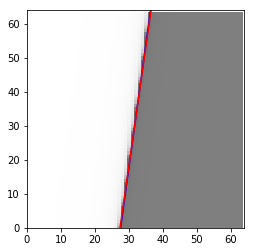

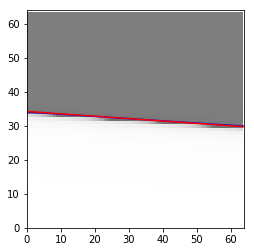

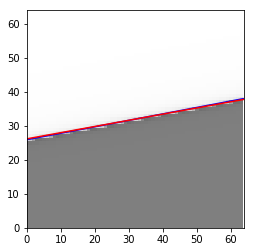

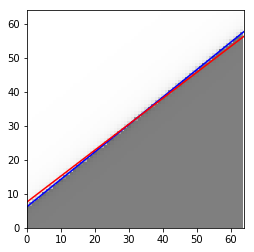

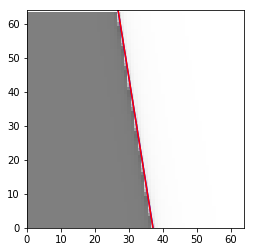

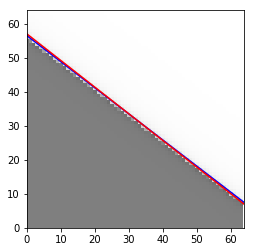

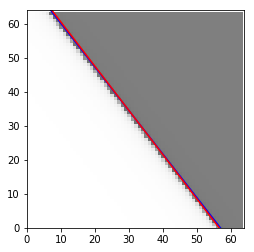

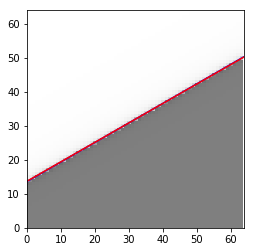

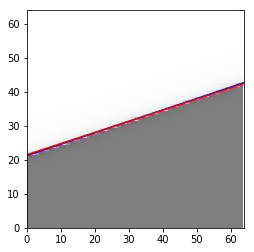

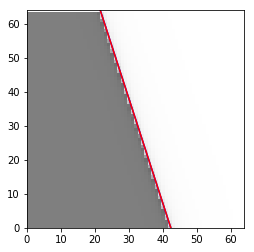

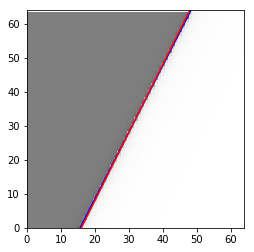

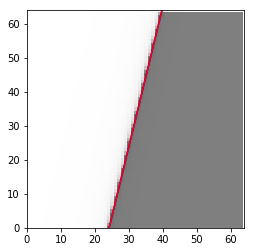

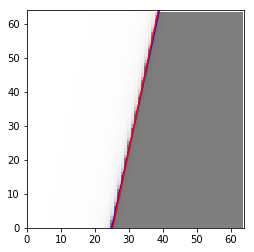

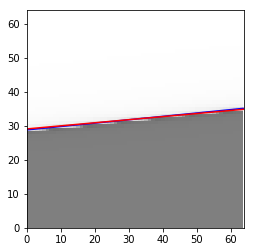

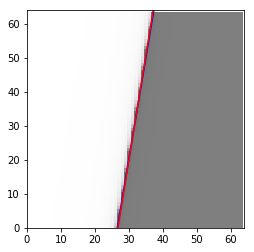

In [33]:
# Plot the Results

model.eval();

for batch_i, data in enumerate(test_loader):
    # get the input images and their corresponding labels
    inputs, output_gt, _, _ = data
    
    inputs, output_gt = inputs.to(dev), output_gt.to(dev)
        
    # forward pass to get outputs
    outputs = model(inputs).squeeze().detach().cpu()
    
    gt = output_gt.cpu().squeeze()
    angle_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0])),axis=1).detach().cpu()
  
for ii in range(15):
    
    plt.figure()
    plt.imshow(inputs[ii].cpu().squeeze(),cmap='gray', vmin=0, vmax=1)
    
    # Plot the ground truth lines
    x_sample = torch.linspace(-1,1,inputs.shape[-1])
    y_sample = -angle_params[ii,0]/angle_params[ii,1]*x_sample
    
    plt.plot(x_sample*32+32,y_sample*32+32,'b')
    plt.xlim([0,64])
    plt.ylim(([0,64]))
    
    # Plot the estimated lines
    y_est = -outputs[ii,0]/outputs[ii,1]*x_sample
    plt.plot(x_sample*32+32,y_est*32+32,'r')



# Centers move within 25% of center

In [16]:
# What about if the centers are allowed to move within 25% of the center?

data_folder = 'foj_data/grayscale_lines/'

with open(data_folder + 'line_data_64_100_grey_bicolor_uncentered.pkl','rb') as f:
    data = pickle.load(f)

# wedges = data['wedges']
wedges_grey = data['wedges_grey']
params = data['params']
boundaries = data['boundaries']
wedges = data['wedges']


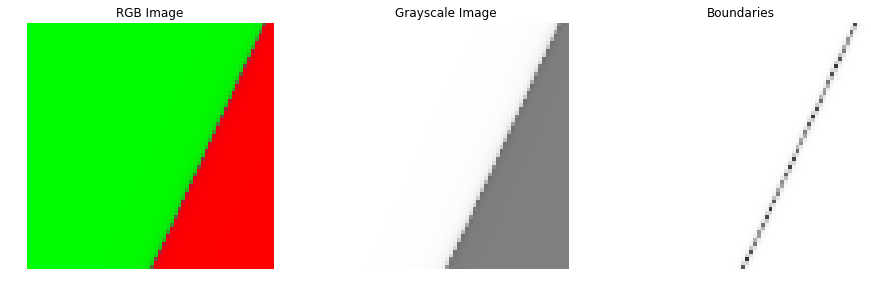

In [23]:
img_show = 0
plt.figure(figsize=[15, 15])
plt.subplot(131)
plt.imshow(wedges[img_show,:,:].squeeze().permute(1,2,0).cpu())
plt.title('RGB Image')
plt.axis('off');
plt.subplot(132)
plt.imshow(wedges_grey[img_show,:,:].squeeze().cpu(),cmap='gray', vmin=0, vmax=1)
plt.title('Grayscale Image')
plt.axis('off');
plt.subplot(133)
plt.imshow(boundaries[img_show,:,:].squeeze().cpu(),cmap='gray', vmin=0, vmax=1)
plt.title('Boundaries')
plt.axis('off');

In [34]:
line_data = LineDataset(wedges_grey, params, boundaries, wedges)#, transform=trainTransform)
data_size = len(line_data)

print(data_size)

train_proportion = .85
# Split dataset into training and testing
train_dataset, test_dataset = torch.utils.data.random_split(line_data, [int(data_size*train_proportion), int(data_size*(1-train_proportion))], generator=torch.Generator().manual_seed(42))

# Create loaders for the training and testing data
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False) #len(test_dataset)



In [26]:
class offCenterlineNet(nn.Module):

    def __init__(self):
        super().__init__()
                
        self.conv1 = nn.Conv2d(1, 128, kernel_size=3)
        self.conv2 = nn.Conv2d(128, 128, kernel_size=3)
        self.conv3 = nn.Conv2d(128, 128, kernel_size=3)
        self.conv4 = nn.Conv2d(128, 64, kernel_size=3)
        self.fc = nn.LazyLinear(3)
    
    def forward(self, x):

        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = x.view(x.shape[0],-1)

        x = self.fc(x)
         
        # We're defining
        # a = - sin(theta)
        # b = cos(theta)
        # c = -cy*cos(theta)+cx*sin(theta)
        # Hence, we want to normalize the vector by 1/sqrt(a^2 + b^2)
        norm_factor = (torch.norm(x[:,:2],p=2,dim=1)).unsqueeze(1)        
        out = x/(norm_factor)#+eps)
#         print('Output shape=',x.shape)
        
        return out
    
model = offCenterlineNet()
model = model.to(dev)
summary(model, input_size=[(1, 64, 64)])

# Now let's train the initial network 

model = offCenterlineNet()
model = model.to(dev)
# model.apply(init_weights)

model.train();

optimizer = torch.optim.Adam(model.parameters(),lr=.000005) #9,635 training parameters

n_epochs = 900

mse_loss = nn.MSELoss()
ce_loss = nn.CrossEntropyLoss()

for epoch in range(0,n_epochs):  # loop over the dataset multiple times

    if epoch == 0:
        train_loss_over_time = [] # to track the loss as the network trains
        test_loss_over_time = []
        
    running_loss = 0
    num_batches = 0
    
    for batch_i, data in enumerate(train_loader):
        
        # get the input images and their corresponding labels
        num_batches += 1

        inputs, output_gt, _, _ = data
        inputs, output_gt = inputs.to(dev), output_gt.to(dev)
        
        # zero the parameter (weight) gradients
        optimizer.zero_grad()
        
        # forward pass to get outputs
        output_line_params = model(inputs)
        

        # make the ground truth
        c = -output_gt[:,2]*torch.cos(output_gt[:,0]) + output_gt[:,1]*torch.sin(output_gt[:,0])
        gt_line_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0]),c),dim=1)
        
        # calculate the loss
#         print(output_line_params[:,:,0,50])
        
        loss = mse_loss(output_line_params,gt_line_params)
        
        # backward pass to calculate the parameter gradients
        loss.backward()

        # update the parameters
        optimizer.step()

        # to convert loss into a scalar and add it to running_loss, we use .item()
        running_loss += loss.item()
      

    # Calculate test data loss after each epoch
    with torch.no_grad():
        test_loss = 0
        num_batches_test = 0
        for batch_i, data in enumerate(test_loader):
            num_batches_test += 1

            # Add code here
            inputs, output_gt, _, _ = data
            inputs, output_gt = inputs.to(dev), output_gt.to(dev)


            # zero the parameter (weight) gradients
            optimizer.zero_grad()

            # forward pass to get outputs
            output_line_params = model(inputs)

            # make the ground truth
            c = -output_gt[:,2]*torch.cos(output_gt[:,0]) + output_gt[:,1]*torch.sin(output_gt[:,0])
            gt_line_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0]),c),dim=1)
    

            # calculate the loss
    #         print(output_line_params[:,:,0,50])

            loss = mse_loss(output_line_params,gt_line_params)
            
            test_loss += loss
                    
        test_loss_over_time.append(test_loss/num_batches_test)


    # Calculate model loss:
    avg_loss = running_loss/num_batches
    train_loss_over_time.append(avg_loss)
    
#     print('Epoch: {}, Avg. Train Loss: {},'.format(epoch + 1, train_loss_over_time[-1]))


    print('Epoch: {}, Avg. Train Loss: {}, Avg. Test Loss: {}'.format(epoch + 1, train_loss_over_time[-1], test_loss_over_time[-1]))
    
print('Finished Training')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 62, 62]           1,280
            Conv2d-2          [-1, 128, 60, 60]         147,584
            Conv2d-3          [-1, 128, 58, 58]         147,584
            Conv2d-4           [-1, 64, 56, 56]          73,792
            Linear-5                    [-1, 3]         602,115
Total params: 972,355
Trainable params: 972,355
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/backward pass size (MB): 12.09
Params size (MB): 3.71
Estimated Total Size (MB): 15.81
----------------------------------------------------------------
Epoch: 1, Avg. Train Loss: 0.5694724682400085, Avg. Test Loss: 0.4931752681732178
Epoch: 2, Avg. Train Loss: 0.38771076010649697, Avg. Test Loss: 0.09364235401153564
Epoch: 3, Avg. Train Loss: 0.0452402322416139, Avg. Test Loss: 0.0

Epoch: 84, Avg. Train Loss: 0.00013248390823184094, Avg. Test Loss: 0.00038042731466703117
Epoch: 85, Avg. Train Loss: 0.0002083546791682773, Avg. Test Loss: 0.00038133273483254015
Epoch: 86, Avg. Train Loss: 0.00017359137594158872, Avg. Test Loss: 0.000562482513487339
Epoch: 87, Avg. Train Loss: 0.00018798656337487367, Avg. Test Loss: 0.0004103115061298013
Epoch: 88, Avg. Train Loss: 9.804641523019467e-05, Avg. Test Loss: 0.00052508560474962
Epoch: 89, Avg. Train Loss: 0.00042815508474150726, Avg. Test Loss: 0.0007244226289913058
Epoch: 90, Avg. Train Loss: 0.0006083879539587275, Avg. Test Loss: 0.000927089829929173
Epoch: 91, Avg. Train Loss: 0.00031947481269633176, Avg. Test Loss: 0.00039639242459088564
Epoch: 92, Avg. Train Loss: 0.00013226890529601993, Avg. Test Loss: 0.00037926071672700346
Epoch: 93, Avg. Train Loss: 0.00012411388157515296, Avg. Test Loss: 0.00043063872726634145
Epoch: 94, Avg. Train Loss: 0.0001030625897770091, Avg. Test Loss: 0.000339776132022962
Epoch: 95, Avg

Epoch: 175, Avg. Train Loss: 1.006837248407986e-05, Avg. Test Loss: 6.501682219095528e-05
Epoch: 176, Avg. Train Loss: 7.968752102773551e-06, Avg. Test Loss: 5.8492045354796574e-05
Epoch: 177, Avg. Train Loss: 1.3567547754726494e-05, Avg. Test Loss: 0.00010455110168550164
Epoch: 178, Avg. Train Loss: 1.3865507774907576e-05, Avg. Test Loss: 9.799272083910182e-05
Epoch: 179, Avg. Train Loss: 3.047570183545812e-05, Avg. Test Loss: 7.158995140343904e-05
Epoch: 180, Avg. Train Loss: 1.0428658456074867e-05, Avg. Test Loss: 6.225980905583128e-05
Epoch: 181, Avg. Train Loss: 9.64634979890006e-06, Avg. Test Loss: 5.9999030781909823e-05
Epoch: 182, Avg. Train Loss: 1.9457205948637078e-05, Avg. Test Loss: 0.00010322841990273446
Epoch: 183, Avg. Train Loss: 1.929208748746907e-05, Avg. Test Loss: 0.00010877992463065311
Epoch: 184, Avg. Train Loss: 4.511487087793351e-05, Avg. Test Loss: 0.00010091896547237411
Epoch: 185, Avg. Train Loss: 8.523134585416033e-05, Avg. Test Loss: 0.00011338983313180506


Epoch: 266, Avg. Train Loss: 3.157438808742712e-05, Avg. Test Loss: 7.522284431615844e-05
Epoch: 267, Avg. Train Loss: 1.5884265355105204e-05, Avg. Test Loss: 6.684085383312777e-05
Epoch: 268, Avg. Train Loss: 1.9632879124575245e-05, Avg. Test Loss: 5.276124647934921e-05
Epoch: 269, Avg. Train Loss: 2.090058883635827e-05, Avg. Test Loss: 0.0001046003817464225
Epoch: 270, Avg. Train Loss: 2.1021039641014152e-05, Avg. Test Loss: 7.046962127787992e-05
Epoch: 271, Avg. Train Loss: 3.9069215938274526e-05, Avg. Test Loss: 0.00010363022011006251
Epoch: 272, Avg. Train Loss: 3.941290235816803e-05, Avg. Test Loss: 7.15855712769553e-05
Epoch: 273, Avg. Train Loss: 3.7120259012494094e-05, Avg. Test Loss: 0.0001211455964948982
Epoch: 274, Avg. Train Loss: 5.630510273215183e-05, Avg. Test Loss: 8.163521124515682e-05
Epoch: 275, Avg. Train Loss: 7.579659139442938e-05, Avg. Test Loss: 9.856965334620327e-05
Epoch: 276, Avg. Train Loss: 3.382199985002685e-05, Avg. Test Loss: 9.230114665115252e-05
Epoch

Epoch: 357, Avg. Train Loss: 1.9468823349116598e-05, Avg. Test Loss: 5.3995692724129185e-05
Epoch: 358, Avg. Train Loss: 1.720381058355676e-05, Avg. Test Loss: 4.668346082326025e-05
Epoch: 359, Avg. Train Loss: 8.538949772852286e-06, Avg. Test Loss: 6.888653297210112e-05
Epoch: 360, Avg. Train Loss: 3.154824403549462e-05, Avg. Test Loss: 4.849949255003594e-05
Epoch: 361, Avg. Train Loss: 3.653557759047116e-05, Avg. Test Loss: 6.039506843080744e-05
Epoch: 362, Avg. Train Loss: 2.1553867139967973e-05, Avg. Test Loss: 7.659779657842591e-05
Epoch: 363, Avg. Train Loss: 5.0363781559781275e-05, Avg. Test Loss: 8.021658140933141e-05
Epoch: 364, Avg. Train Loss: 0.00010226352575557485, Avg. Test Loss: 7.550674490630627e-05
Epoch: 365, Avg. Train Loss: 5.8759223473798024e-05, Avg. Test Loss: 0.00010775133705465123
Epoch: 366, Avg. Train Loss: 4.730239946222609e-05, Avg. Test Loss: 0.00011722987983375788
Epoch: 367, Avg. Train Loss: 4.264823985121278e-05, Avg. Test Loss: 7.124450348783284e-05
Ep

Epoch: 448, Avg. Train Loss: 1.0263202387213422e-05, Avg. Test Loss: 4.177842129138298e-05
Epoch: 449, Avg. Train Loss: 1.1830615380691758e-05, Avg. Test Loss: 5.232508192420937e-05
Epoch: 450, Avg. Train Loss: 1.773000180955197e-05, Avg. Test Loss: 5.6099659559549764e-05
Epoch: 451, Avg. Train Loss: 1.0358247336024064e-05, Avg. Test Loss: 4.263232403900474e-05
Epoch: 452, Avg. Train Loss: 9.42190453355686e-06, Avg. Test Loss: 4.3276373617118225e-05
Epoch: 453, Avg. Train Loss: 2.5550765783405642e-05, Avg. Test Loss: 4.89943558932282e-05
Epoch: 454, Avg. Train Loss: 2.1753598229131112e-05, Avg. Test Loss: 9.383141150465235e-05
Epoch: 455, Avg. Train Loss: 6.593634372473602e-05, Avg. Test Loss: 0.0001707580522634089
Epoch: 456, Avg. Train Loss: 0.00018077629524936234, Avg. Test Loss: 0.00016276015958283097
Epoch: 457, Avg. Train Loss: 3.9948054633749264e-05, Avg. Test Loss: 7.312914385693148e-05
Epoch: 458, Avg. Train Loss: 1.8532434724500706e-05, Avg. Test Loss: 4.83004841953516e-05
Ep

Epoch: 539, Avg. Train Loss: 1.4549644099722226e-05, Avg. Test Loss: 6.18329067947343e-05
Epoch: 540, Avg. Train Loss: 1.4718304047952014e-05, Avg. Test Loss: 5.6812747061485425e-05
Epoch: 541, Avg. Train Loss: 1.0722173747393861e-05, Avg. Test Loss: 5.036499351263046e-05
Epoch: 542, Avg. Train Loss: 9.628560906334539e-06, Avg. Test Loss: 4.152770634391345e-05
Epoch: 543, Avg. Train Loss: 7.173612092134028e-06, Avg. Test Loss: 4.8726535169407725e-05
Epoch: 544, Avg. Train Loss: 1.558974059555433e-05, Avg. Test Loss: 5.152179073775187e-05
Epoch: 545, Avg. Train Loss: 1.276541144955241e-05, Avg. Test Loss: 5.1202445320086554e-05
Epoch: 546, Avg. Train Loss: 9.958758271324923e-06, Avg. Test Loss: 7.19637973816134e-05
Epoch: 547, Avg. Train Loss: 2.4046183102989422e-05, Avg. Test Loss: 6.147127714939415e-05
Epoch: 548, Avg. Train Loss: 1.3904024267971822e-05, Avg. Test Loss: 4.0187875129049644e-05
Epoch: 549, Avg. Train Loss: 5.718685526817319e-06, Avg. Test Loss: 3.958069646614604e-05
Epo

Epoch: 630, Avg. Train Loss: 4.2389065190290615e-05, Avg. Test Loss: 5.236037395661697e-05
Epoch: 631, Avg. Train Loss: 2.4672643753413414e-05, Avg. Test Loss: 3.91777248296421e-05
Epoch: 632, Avg. Train Loss: 1.6606118252415106e-05, Avg. Test Loss: 4.498988710111007e-05
Epoch: 633, Avg. Train Loss: 1.2068872905501848e-05, Avg. Test Loss: 6.0161659348523244e-05
Epoch: 634, Avg. Train Loss: 5.397166342751133e-06, Avg. Test Loss: 2.9681395972147584e-05
Epoch: 635, Avg. Train Loss: 4.636360735894443e-06, Avg. Test Loss: 2.3025719201541506e-05
Epoch: 636, Avg. Train Loss: 8.462379042254377e-06, Avg. Test Loss: 3.678910434246063e-05
Epoch: 637, Avg. Train Loss: 1.0531115517618245e-05, Avg. Test Loss: 4.6114291762933135e-05
Epoch: 638, Avg. Train Loss: 8.02213742550171e-06, Avg. Test Loss: 4.6750774345127866e-05
Epoch: 639, Avg. Train Loss: 8.943151236200506e-06, Avg. Test Loss: 3.8652604416711256e-05
Epoch: 640, Avg. Train Loss: 6.074568017165033e-06, Avg. Test Loss: 2.809092438837979e-05
E

KeyboardInterrupt: 

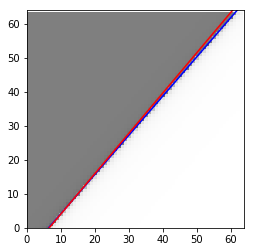

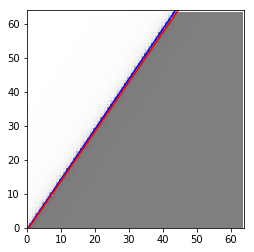

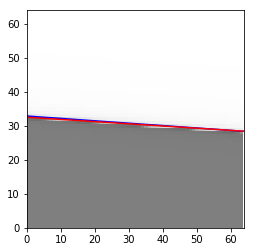

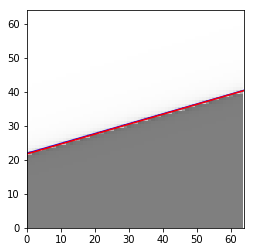

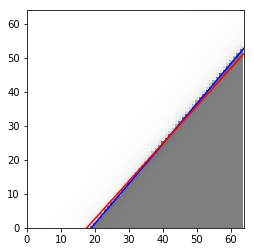

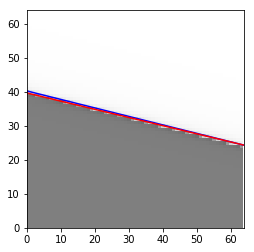

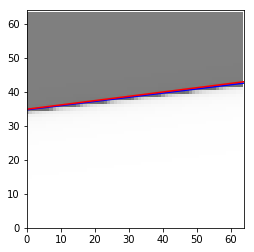

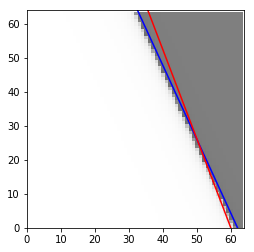

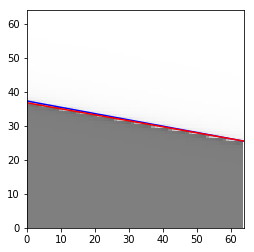

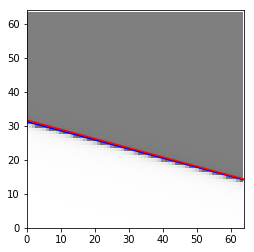

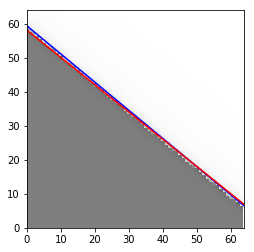

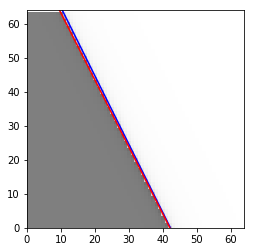

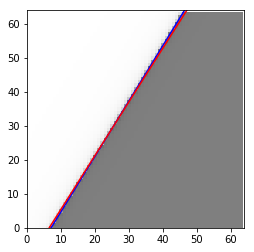

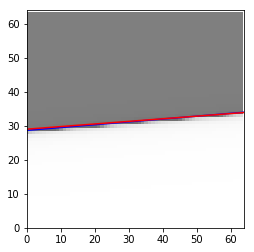

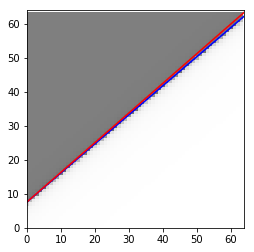

In [28]:
# Plot the Results

# Results are surprisingly good with 13k parameters
# Let's start monitoring generalizability

model.eval();

for batch_i, data in enumerate(test_loader):
    # get the input images and their corresponding labels
    inputs, output_gt, _, _ = data
    inputs, output_gt = inputs.to(dev), output_gt.to(dev)
        
    # forward pass to get outputs
    outputs = model(inputs).squeeze().detach().cpu()
    
    c = -output_gt[:,2]*torch.cos(output_gt[:,0]) + output_gt[:,1]*torch.sin(output_gt[:,0])
    angle_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0]),c),axis=1).detach().cpu()
  
for ii in range(15):
    
    plt.figure()
    plt.imshow(inputs[ii].cpu().squeeze(),cmap='gray', vmin=0, vmax=1)
    
    # Plot the ground truth lines
    x_sample = torch.linspace(-1,1,inputs.shape[-1])
    y_sample = -angle_params[ii,0]/angle_params[ii,1]*x_sample - angle_params[ii,2]/angle_params[ii,1]
    
    plt.plot(x_sample*32+32,y_sample*32+32,'b')
    plt.xlim([0,64])
    plt.ylim(([0,64]))
    
    # Plot the estimated lines
    y_est = -outputs[ii,0]/outputs[ii,1]*x_sample - outputs[ii,2]/outputs[ii,1]
    plt.plot(x_sample*32+32,y_est*32+32,'r')




# Centered Line with varying colors

In [47]:
data_folder = 'foj_data/grayscale_lines/'

with open(data_folder + 'line_data_64_10000_grey_multicolor_centered.pkl','rb') as f:
    data = pickle.load(f)

# wedges = data['wedges']
wedges_grey = data['wedges_grey']
params = data['params']
boundaries = data['boundaries']
wedges = data['wedges']


In [48]:
line_data = LineDataset(wedges_grey, params, boundaries, wedges)#, transform=trainTransform)
data_size = len(line_data)

print(data_size)

train_proportion = .85
# Split dataset into training and testing
train_dataset, test_dataset = torch.utils.data.random_split(line_data, [int(data_size*train_proportion), int(data_size*(1-train_proportion))], generator=torch.Generator().manual_seed(42))

# Create loaders for the training and testing data
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False) #len(test_dataset)


10000


In [49]:
class greyLineNet(nn.Module):

    def __init__(self):
        super().__init__()
                
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3)
        self.fc = nn.LazyLinear(2)
        self.maxpool = nn.MaxPool2d(2)
    
    def forward(self, x):

        x = self.conv1(x)
        x = F.relu(self.maxpool(x))
        x = self.conv2(x)
        x = F.relu(self.maxpool(x))
        x = x.view(x.shape[0],-1)
        x = self.fc(x)
         
        # We're defining
        # a = - sin(theta)
        # b = cos(theta)
        # c = -cy*cos(theta)+cx*sin(theta)
        # Hence, we want to normalize the vector by 1/sqrt(a^2 + b^2)
        norm_factor = (torch.norm(x,p=2,dim=1)).unsqueeze(1)        
        out = x/(norm_factor)#+eps)

        return out
    
model = greyLineNet()
model = model.to(dev)
summary(model, input_size=[(1, 64, 64)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 62, 62]             640
         MaxPool2d-2           [-1, 64, 31, 31]               0
            Conv2d-3           [-1, 64, 29, 29]          36,928
         MaxPool2d-4           [-1, 64, 14, 14]               0
            Linear-5                    [-1, 2]          25,090
Total params: 62,658
Trainable params: 62,658
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/backward pass size (MB): 2.85
Params size (MB): 0.24
Estimated Total Size (MB): 3.11
----------------------------------------------------------------


In [50]:
# Now let's train the initial network 

model = greyLineNet()
model = model.to(dev)
# model.apply(init_weights)

model.train();

optimizer = torch.optim.Adam(model.parameters(),lr=.0001)

n_epochs = 600

mse_loss = nn.MSELoss()
ce_loss = nn.CrossEntropyLoss()

for epoch in range(0,1200):  # loop over the dataset multiple times

    if epoch == 0:
        train_loss_over_time = [] # to track the loss as the network trains
        test_loss_over_time = []
        
    running_loss = 0
    num_batches = 0
    
    for batch_i, data in enumerate(train_loader):
        
        # get the input images and their corresponding labels
        num_batches += 1

        inputs, output_gt, _, _ = data
        inputs, output_gt = inputs.to(dev), output_gt.to(dev)
        
        # zero the parameter (weight) gradients
        optimizer.zero_grad()
        
        # forward pass to get outputs
        output_line_params = model(inputs)

        # make the ground truth
        gt_line_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0])),dim=1)
        
        # calculate the loss
#         print(output_line_params[:,:,0,50])
        
        loss = mse_loss(output_line_params,gt_line_params)
        
#         if batch_i==0:
#             plt.figure()
#             plt.imshow(output_line_params[0].cpu().detach().permute(1,2,0))
#             plt.title('NN Line Param Output')

#             plt.figure()
#             plt.imshow((((output_line_params-line_params_gt.permute(0,3,1,2))*(confidence_gt.unsqueeze(1)))**2)[0].permute(1,2,0).cpu().detach())
#             plt.title('Loss Visualization')

#         sys.quit()
        
        
        # backward pass to calculate the parameter gradients
        loss.backward()

        # update the parameters
        optimizer.step()

        # to convert loss into a scalar and add it to running_loss, we use .item()
        running_loss += loss.item()
      

    # Calculate test data loss after each epoch
    with torch.no_grad():
        test_loss = 0
        num_batches_test = 0
        for batch_i, data in enumerate(test_loader):
            num_batches_test += 1

            # Add code here
            inputs, output_gt, _, _ = data
            inputs, output_gt = inputs.to(dev), output_gt.to(dev)


            # zero the parameter (weight) gradients
            optimizer.zero_grad()

            # forward pass to get outputs
            output_line_params = model(inputs)

            # make the ground truth
            gt_line_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0])),dim=1)

            # calculate the loss
    #         print(output_line_params[:,:,0,50])

            loss = mse_loss(output_line_params,gt_line_params)
            
            test_loss += loss
                    
        test_loss_over_time.append(test_loss/num_batches_test)


    # Calculate model loss:
    avg_loss = running_loss/num_batches
    train_loss_over_time.append(avg_loss)
    
#     print('Epoch: {}, Avg. Train Loss: {},'.format(epoch + 1, train_loss_over_time[-1]))


    print('Epoch: {}, Avg. Train Loss: {}, Avg. Test Loss: {}'.format(epoch + 1, train_loss_over_time[-1], test_loss_over_time[-1]))
    
print('Finished Training')

Epoch: 1, Avg. Train Loss: 1.0092475729830124, Avg. Test Loss: 0.9888307452201843
Epoch: 2, Avg. Train Loss: 1.0079388239804437, Avg. Test Loss: 0.9903808832168579
Epoch: 3, Avg. Train Loss: 1.0039216819931478, Avg. Test Loss: 1.001448154449463
Epoch: 4, Avg. Train Loss: 0.9979869597098406, Avg. Test Loss: 1.0054773092269897
Epoch: 5, Avg. Train Loss: 0.9953684582429774, Avg. Test Loss: 1.0100646018981934
Epoch: 6, Avg. Train Loss: 0.9934379416353563, Avg. Test Loss: 1.0103405714035034
Epoch: 7, Avg. Train Loss: 0.9779091708800371, Avg. Test Loss: 1.009153127670288
Epoch: 8, Avg. Train Loss: 0.9937410165281857, Avg. Test Loss: 1.0048748254776
Epoch: 9, Avg. Train Loss: 0.9900321140008814, Avg. Test Loss: 0.9887263774871826
Epoch: 10, Avg. Train Loss: 0.9918576822561376, Avg. Test Loss: 1.0030542612075806
Epoch: 11, Avg. Train Loss: 0.9790518655496485, Avg. Test Loss: 0.9779639840126038
Epoch: 12, Avg. Train Loss: 0.9679098164334017, Avg. Test Loss: 0.981453537940979
Epoch: 13, Avg. Tra

Epoch: 100, Avg. Train Loss: 0.3308606926132651, Avg. Test Loss: 0.3354961574077606
Epoch: 101, Avg. Train Loss: 0.31937989592552185, Avg. Test Loss: 0.3005571961402893
Epoch: 102, Avg. Train Loss: 0.29039925950414996, Avg. Test Loss: 0.29845112562179565
Epoch: 103, Avg. Train Loss: 0.2882044336375068, Avg. Test Loss: 0.3029381036758423
Epoch: 104, Avg. Train Loss: 0.2941761144820382, Avg. Test Loss: 0.30965885519981384
Epoch: 105, Avg. Train Loss: 0.2889164493364446, Avg. Test Loss: 0.3207637071609497
Epoch: 106, Avg. Train Loss: 0.2863412364440806, Avg. Test Loss: 0.32546496391296387
Epoch: 107, Avg. Train Loss: 0.290615845953717, Avg. Test Loss: 0.28416091203689575
Epoch: 108, Avg. Train Loss: 0.2698066433562952, Avg. Test Loss: 0.2813875675201416
Epoch: 109, Avg. Train Loss: 0.29709961659768047, Avg. Test Loss: 0.3016597628593445
Epoch: 110, Avg. Train Loss: 0.2967312260585673, Avg. Test Loss: 0.28176984190940857
Epoch: 111, Avg. Train Loss: 0.27105141527512494, Avg. Test Loss: 0.3

Epoch: 197, Avg. Train Loss: 0.14938847540932543, Avg. Test Loss: 0.19345179200172424
Epoch: 198, Avg. Train Loss: 0.1389062837642782, Avg. Test Loss: 0.11431349068880081
Epoch: 199, Avg. Train Loss: 0.12489050465690739, Avg. Test Loss: 0.11062844097614288
Epoch: 200, Avg. Train Loss: 0.13077335997539408, Avg. Test Loss: 0.11719494313001633
Epoch: 201, Avg. Train Loss: 0.13432022710056865, Avg. Test Loss: 0.12005259841680527
Epoch: 202, Avg. Train Loss: 0.13259690364494042, Avg. Test Loss: 0.11377190798521042
Epoch: 203, Avg. Train Loss: 0.15202514914905324, Avg. Test Loss: 0.1359129250049591
Epoch: 204, Avg. Train Loss: 0.14363454812589813, Avg. Test Loss: 0.10665938258171082
Epoch: 205, Avg. Train Loss: 0.12925159501678804, Avg. Test Loss: 0.13106179237365723
Epoch: 206, Avg. Train Loss: 0.1391559531145236, Avg. Test Loss: 0.11487462371587753
Epoch: 207, Avg. Train Loss: 0.19088408359709907, Avg. Test Loss: 0.22068357467651367
Epoch: 208, Avg. Train Loss: 0.1786763137754272, Avg. Tes

Epoch: 293, Avg. Train Loss: 0.08605142288348254, Avg. Test Loss: 0.0656082034111023
Epoch: 294, Avg. Train Loss: 0.061746944377527514, Avg. Test Loss: 0.043552495539188385
Epoch: 295, Avg. Train Loss: 0.05767159595647279, Avg. Test Loss: 0.04432838037610054
Epoch: 296, Avg. Train Loss: 0.06014810927650508, Avg. Test Loss: 0.04829636588692665
Epoch: 297, Avg. Train Loss: 0.05316076309365385, Avg. Test Loss: 0.0402948334813118
Epoch: 298, Avg. Train Loss: 0.05930070506737513, Avg. Test Loss: 0.07618584483861923
Epoch: 299, Avg. Train Loss: 0.06708177483695395, Avg. Test Loss: 0.056755341589450836
Epoch: 300, Avg. Train Loss: 0.05314027368200614, Avg. Test Loss: 0.03938307613134384
Epoch: 301, Avg. Train Loss: 0.053503258972812225, Avg. Test Loss: 0.10781626403331757
Epoch: 302, Avg. Train Loss: 0.07634841073304414, Avg. Test Loss: 0.08097940683364868
Epoch: 303, Avg. Train Loss: 0.05931997564895188, Avg. Test Loss: 0.04343156889081001
Epoch: 304, Avg. Train Loss: 0.05407892263987485, Av

Epoch: 387, Avg. Train Loss: 0.0018640585380661136, Avg. Test Loss: 0.004724807571619749
Epoch: 388, Avg. Train Loss: 0.0018277021775515202, Avg. Test Loss: 0.003873585257679224
Epoch: 389, Avg. Train Loss: 0.0017819306922747808, Avg. Test Loss: 0.0039387964643538
Epoch: 390, Avg. Train Loss: 0.0017458424280288026, Avg. Test Loss: 0.0038859343621879816
Epoch: 391, Avg. Train Loss: 0.0017444945981397349, Avg. Test Loss: 0.004152792040258646
Epoch: 392, Avg. Train Loss: 0.0017279595355777179, Avg. Test Loss: 0.0040982565842568874
Epoch: 393, Avg. Train Loss: 0.02275816661867258, Avg. Test Loss: 0.11426080018281937
Epoch: 394, Avg. Train Loss: 0.05181225605089875, Avg. Test Loss: 0.07901372760534286
Epoch: 395, Avg. Train Loss: 0.03719440883244662, Avg. Test Loss: 0.014592869207262993
Epoch: 396, Avg. Train Loss: 0.004145507203579387, Avg. Test Loss: 0.005469413008540869
Epoch: 397, Avg. Train Loss: 0.003246455729993827, Avg. Test Loss: 0.009665660560131073
Epoch: 398, Avg. Train Loss: 0.

Epoch: 480, Avg. Train Loss: 0.002413921616971493, Avg. Test Loss: 0.003724594134837389
Epoch: 481, Avg. Train Loss: 0.0022547462462064096, Avg. Test Loss: 0.0032088770531117916
Epoch: 482, Avg. Train Loss: 0.002114843830521054, Avg. Test Loss: 0.0030091030057519674
Epoch: 483, Avg. Train Loss: 0.0020610982113901306, Avg. Test Loss: 0.0028835900593549013
Epoch: 484, Avg. Train Loss: 0.001974099110264112, Avg. Test Loss: 0.003347046673297882
Epoch: 485, Avg. Train Loss: 0.0016954577014343265, Avg. Test Loss: 0.0027278615161776543
Epoch: 486, Avg. Train Loss: 0.001573114428559647, Avg. Test Loss: 0.0025063392240554094


KeyboardInterrupt: 

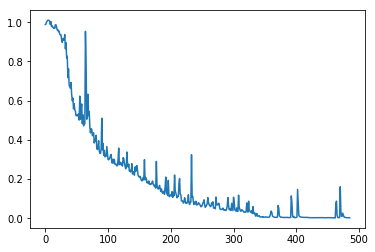

In [51]:
plt.figure()
plt.plot(test_loss_over_time)

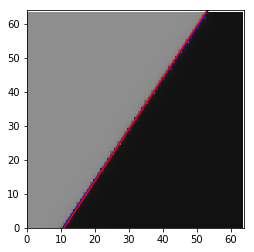

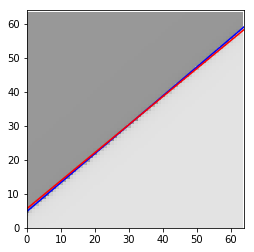

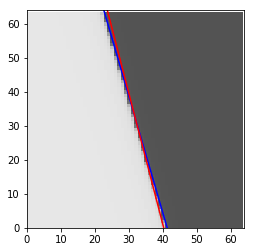

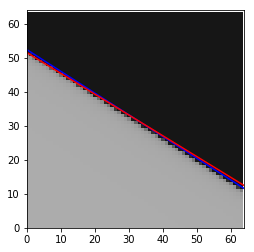

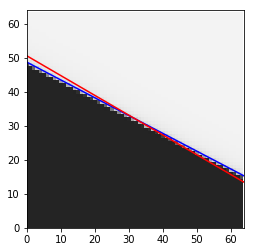

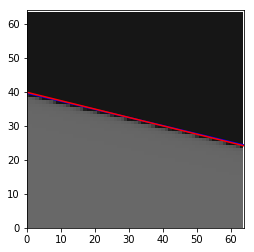

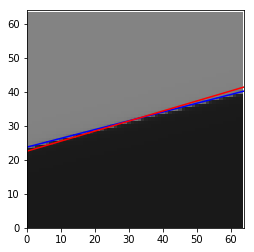

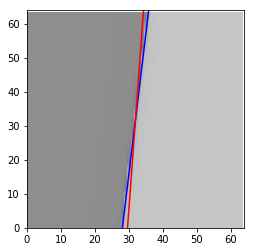

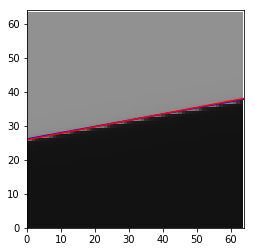

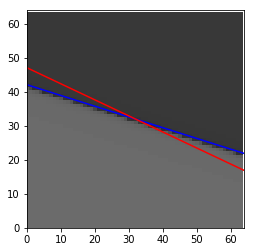

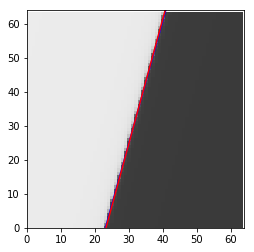

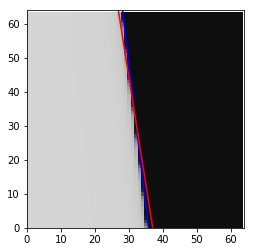

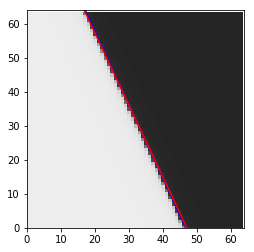

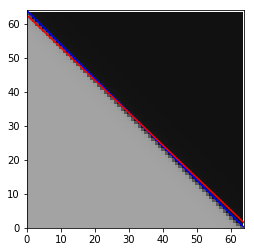

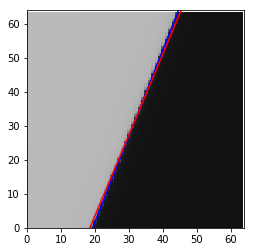

In [52]:
# Plot the Results

model.eval();

for batch_i, data in enumerate(test_loader):
    # get the input images and their corresponding labels
    inputs, output_gt, _, _ = data
    
    inputs, output_gt = inputs.to(dev), output_gt.to(dev)
        
    # forward pass to get outputs
    outputs = model(inputs).squeeze().detach().cpu()
    
    gt = output_gt.cpu().squeeze()
    angle_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0])),axis=1).detach().cpu()
  
for ii in range(15):
    
    plt.figure()
    plt.imshow(inputs[ii].cpu().squeeze(),cmap='gray', vmin=0, vmax=1)
    
    # Plot the ground truth lines
    x_sample = torch.linspace(-1,1,inputs.shape[-1])
    y_sample = -angle_params[ii,0]/angle_params[ii,1]*x_sample
    
    plt.plot(x_sample*32+32,y_sample*32+32,'b')
    plt.xlim([0,64])
    plt.ylim(([0,64]))
    
    # Plot the estimated lines
    y_est = -outputs[ii,0]/outputs[ii,1]*x_sample
    plt.plot(x_sample*32+32,y_est*32+32,'r')






# Non-Centered Line with Varying Colors

In [53]:
data_folder = 'foj_data/grayscale_lines/'

with open(data_folder + 'line_data_64_10000_grey_multicolor_uncentered.pkl','rb') as f:
    data = pickle.load(f)

# wedges = data['wedges']
wedges_grey = data['wedges_grey']
params = data['params']
boundaries = data['boundaries']
wedges = data['wedges']


line_data = LineDataset(wedges_grey, params, boundaries, wedges)#, transform=trainTransform)
data_size = len(line_data)

print(data_size)

train_proportion = .85
# Split dataset into training and testing
train_dataset, test_dataset = torch.utils.data.random_split(line_data, [int(data_size*train_proportion), int(data_size*(1-train_proportion))], generator=torch.Generator().manual_seed(42))

# Create loaders for the training and testing data
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False) #len(test_dataset)



10000


In [54]:
class offCenterGreylineNet(nn.Module):

    def __init__(self):
        super().__init__()
                
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3)
        self.fc = nn.LazyLinear(3)
        self.maxpool = nn.MaxPool2d(2)
    
    def forward(self, x):

        x = self.conv1(x)
        x = F.relu(self.maxpool(x))
        x = self.conv2(x)
        x = F.relu(self.maxpool(x))
        x = self.conv3(x)
        x = F.relu(self.maxpool(x))
#         x = self.conv4(x)
#         x = F.relu(self.maxpool(x))
        x = x.view(x.shape[0],-1)
        x = self.fc(x)
        
        # We're defining
        # a = - sin(theta)
        # b = cos(theta)
        # c = -cy*cos(theta)+cx*sin(theta)
        # Hence, we want to normalize the vector by 1/sqrt(a^2 + b^2)
        norm_factor = (torch.norm(x[:,:2],p=2,dim=1)).unsqueeze(1)        
        out = x/(norm_factor)#+eps)
#         print('Output shape=',x.shape)
        
        return out
    
model = offCenterGreylineNet()
model = model.to(dev)
summary(model, input_size=[(1, 64, 64)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 62, 62]             640
         MaxPool2d-2           [-1, 64, 31, 31]               0
            Conv2d-3           [-1, 64, 29, 29]          36,928
         MaxPool2d-4           [-1, 64, 14, 14]               0
            Conv2d-5           [-1, 64, 12, 12]          36,928
         MaxPool2d-6             [-1, 64, 6, 6]               0
            Linear-7                    [-1, 3]           6,915
Total params: 81,411
Trainable params: 81,411
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/backward pass size (MB): 2.94
Params size (MB): 0.31
Estimated Total Size (MB): 3.27
----------------------------------------------------------------


In [58]:
model = offCenterGreylineNet()
model = model.to(dev)
# model.apply(init_weights)

model.train();

optimizer = torch.optim.Adam(model.parameters(),lr=.000005)

n_epochs = 450

mse_loss = nn.MSELoss()
ce_loss = nn.CrossEntropyLoss()

for epoch in range(0,n_epochs):  # loop over the dataset multiple times

    if epoch == 0:
        train_loss_over_time = [] # to track the loss as the network trains
        test_loss_over_time = []
        
    running_loss = 0
    num_batches = 0
    
    for batch_i, data in enumerate(train_loader):
        
        # get the input images and their corresponding labels
        num_batches += 1

        inputs, output_gt, _, _ = data
        inputs, output_gt = inputs.to(dev), output_gt.to(dev)
        
        # zero the parameter (weight) gradients
        optimizer.zero_grad()
        
        # forward pass to get outputs
        output_line_params = model(inputs)
        

        # make the ground truth
        c = -output_gt[:,2]*torch.cos(output_gt[:,0]) + output_gt[:,1]*torch.sin(output_gt[:,0])
        gt_line_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0]),c),dim=1)
        
        # calculate the loss
#         print(output_line_params[:,:,0,50])
        
        loss = mse_loss(output_line_params,gt_line_params)
        
        # backward pass to calculate the parameter gradients
        loss.backward()

        # update the parameters
        optimizer.step()

        # to convert loss into a scalar and add it to running_loss, we use .item()
        running_loss += loss.item()
      

    # Calculate test data loss after each epoch
    with torch.no_grad():
        test_loss = 0
        num_batches_test = 0
        for batch_i, data in enumerate(test_loader):
            num_batches_test += 1

            # Add code here
            inputs, output_gt, _, _ = data
            inputs, output_gt = inputs.to(dev), output_gt.to(dev)


            # zero the parameter (weight) gradients
            optimizer.zero_grad()

            # forward pass to get outputs
            output_line_params = model(inputs)

            # make the ground truth
            c = -output_gt[:,2]*torch.cos(output_gt[:,0]) + output_gt[:,1]*torch.sin(output_gt[:,0])
            gt_line_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0]),c),dim=1)
    

            # calculate the loss
    #         print(output_line_params[:,:,0,50])

            loss = mse_loss(output_line_params,gt_line_params)
            
            test_loss += loss
                    
        test_loss_over_time.append(test_loss/num_batches_test)


    # Calculate model loss:
    avg_loss = running_loss/num_batches
    train_loss_over_time.append(avg_loss)
    
#     print('Epoch: {}, Avg. Train Loss: {},'.format(epoch + 1, train_loss_over_time[-1]))


    print('Epoch: {}, Avg. Train Loss: {}, Avg. Test Loss: {}'.format(epoch + 1, train_loss_over_time[-1], test_loss_over_time[-1]))
    
print('Finished Training')

Epoch: 1, Avg. Train Loss: 0.7104588445495157, Avg. Test Loss: 0.688130795955658
Epoch: 2, Avg. Train Loss: 0.6900698325213264, Avg. Test Loss: 0.6842411160469055
Epoch: 3, Avg. Train Loss: 0.6877214130233316, Avg. Test Loss: 0.6830714344978333
Epoch: 4, Avg. Train Loss: 0.6869662936996012, Avg. Test Loss: 0.6827175617218018
Epoch: 5, Avg. Train Loss: 0.6867019653320312, Avg. Test Loss: 0.6825754046440125
Epoch: 6, Avg. Train Loss: 0.6863953387036043, Avg. Test Loss: 0.6824311017990112
Epoch: 7, Avg. Train Loss: 0.6862572038874907, Avg. Test Loss: 0.6824148297309875
Epoch: 8, Avg. Train Loss: 0.6861739810775308, Avg. Test Loss: 0.6823039054870605
Epoch: 9, Avg. Train Loss: 0.6859581386341768, Avg. Test Loss: 0.6822925209999084
Epoch: 10, Avg. Train Loss: 0.6860046702272752, Avg. Test Loss: 0.6822758913040161
Epoch: 11, Avg. Train Loss: 0.6858592615408056, Avg. Test Loss: 0.6822067499160767
Epoch: 12, Avg. Train Loss: 0.6856657652293935, Avg. Test Loss: 0.6822454333305359
Epoch: 13, Avg

KeyboardInterrupt: 

# Learning displacements 

In [59]:
class displacementNet(nn.Module):

    def __init__(self):
        super().__init__()
                
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3)
        self.fc = nn.LazyLinear(2)
        self.maxpool = nn.MaxPool2d(2)
    
    def forward(self, x):

        x = self.conv1(x)
        x = F.relu(self.maxpool(x))
        x = self.conv2(x)
        x = F.relu(self.maxpool(x))
#         x = self.conv3(x)
#         x = F.relu(self.maxpool(x))
#         x = self.conv4(x)
#         x = F.relu(self.maxpool(x))
        x = x.view(x.shape[0],-1)
        x = self.fc(x)
        
        # We're defining
        # a = - sin(theta)
        # b = cos(theta)
        # c = -cy*cos(theta)+cx*sin(theta)
        # Hence, we want to normalize the vector by 1/sqrt(a^2 + b^2)
#         norm_factor = (torch.norm(x[:,:2],p=2,dim=1)).unsqueeze(1)        
#         out = x/(norm_factor)#+eps)
#         print('Output shape=',x.shape)

        out = x
        
        return out
    
model = displacementNet()
model = model.to(dev)
summary(model, input_size=[(1, 64, 64)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 62, 62]             640
         MaxPool2d-2           [-1, 64, 31, 31]               0
            Conv2d-3           [-1, 64, 29, 29]          36,928
         MaxPool2d-4           [-1, 64, 14, 14]               0
            Linear-5                    [-1, 2]          25,090
Total params: 62,658
Trainable params: 62,658
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/backward pass size (MB): 2.85
Params size (MB): 0.24
Estimated Total Size (MB): 3.11
----------------------------------------------------------------


In [60]:
model = displacementNet()
model = model.to(dev)
# model.apply(init_weights)

model.train();

optimizer = torch.optim.Adam(model.parameters(),lr=.0001)

n_epochs = 400

mse_loss = nn.MSELoss()
ce_loss = nn.CrossEntropyLoss()

for epoch in range(0,n_epochs):  # loop over the dataset multiple times

    if epoch == 0:
        train_loss_over_time = [] # to track the loss as the network trains
        test_loss_over_time = []
        
    running_loss = 0
    num_batches = 0
    
    for batch_i, data in enumerate(train_loader):
        
        # get the input images and their corresponding labels
        num_batches += 1

        inputs, output_gt, _, _ = data
        inputs, output_gt = inputs.to(dev), output_gt.to(dev)
        
        # zero the parameter (weight) gradients
        optimizer.zero_grad()
        
        # forward pass to get outputs
        output_line_params = torch.cat((model(inputs),torch.ones((len(inputs),1),device=dev)),dim=1)
        
        # make the ground truth
        c = -output_gt[:,2]*torch.cos(output_gt[:,0]) + output_gt[:,1]*torch.sin(output_gt[:,0])
        gt_line_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0]),c),dim=1)
        
        
        # calculate the loss
#         print(output_line_params[:,:,0,50])
        loss = torch.mean(torch.abs(torch.sum(gt_line_params*output_line_params,1))) 
#         loss = mse_loss(output_line_params,gt_line_params)
        
        # backward pass to calculate the parameter gradients
        loss.backward()

        # update the parameters
        optimizer.step()

        # to convert loss into a scalar and add it to running_loss, we use .item()
        running_loss += loss.item()
      

    # Calculate test data loss after each epoch
    with torch.no_grad():
        test_loss = 0
        num_batches_test = 0
        for batch_i, data in enumerate(test_loader):
            num_batches_test += 1

            # Add code here
            inputs, output_gt, _, _ = data
            inputs, output_gt = inputs.to(dev), output_gt.to(dev)


            # zero the parameter (weight) gradients
            optimizer.zero_grad()

             # forward pass to get outputs
            output_line_params = torch.cat((model(inputs),torch.ones((len(inputs),1),device=dev)),dim=1)

            # make the ground truth
            c = -output_gt[:,2]*torch.cos(output_gt[:,0]) + output_gt[:,1]*torch.sin(output_gt[:,0])
            gt_line_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0]),c),dim=1)


            # calculate the loss
            loss = torch.mean(torch.abs(torch.sum(gt_line_params*output_line_params,1)))
            
            test_loss += loss
                    
        test_loss_over_time.append(test_loss/num_batches_test)


    # Calculate model loss:
    avg_loss = running_loss/num_batches
    train_loss_over_time.append(avg_loss)
    
#     print('Epoch: {}, Avg. Train Loss: {},'.format(epoch + 1, train_loss_over_time[-1]))


    print('Epoch: {}, Avg. Train Loss: {}, Avg. Test Loss: {}'.format(epoch + 1, train_loss_over_time[-1], test_loss_over_time[-1]))
    
print('Finished Training')

Epoch: 1, Avg. Train Loss: 0.1640501880470444, Avg. Test Loss: 0.11982840299606323
Epoch: 2, Avg. Train Loss: 0.09036917370908401, Avg. Test Loss: 0.0796487107872963
Epoch: 3, Avg. Train Loss: 0.07454730824512594, Avg. Test Loss: 0.07615692168474197
Epoch: 4, Avg. Train Loss: 0.06744833579834769, Avg. Test Loss: 0.07161834090948105
Epoch: 5, Avg. Train Loss: 0.05982509969788439, Avg. Test Loss: 0.05715423822402954
Epoch: 6, Avg. Train Loss: 0.0487214112544761, Avg. Test Loss: 0.04219682514667511
Epoch: 7, Avg. Train Loss: 0.04178165241199381, Avg. Test Loss: 0.03968457132577896
Epoch: 8, Avg. Train Loss: 0.037103292192606364, Avg. Test Loss: 0.0388529971241951
Epoch: 9, Avg. Train Loss: 0.03371268405633814, Avg. Test Loss: 0.03298557549715042
Epoch: 10, Avg. Train Loss: 0.031177107069422217, Avg. Test Loss: 0.03280951827764511
Epoch: 11, Avg. Train Loss: 0.029377085080041606, Avg. Test Loss: 0.025305427610874176
Epoch: 12, Avg. Train Loss: 0.025396426591803047, Avg. Test Loss: 0.023357

Epoch: 96, Avg. Train Loss: 0.008375531867803897, Avg. Test Loss: 0.01006364170461893
Epoch: 97, Avg. Train Loss: 0.008073894367279375, Avg. Test Loss: 0.009085634723305702
Epoch: 98, Avg. Train Loss: 0.009049097481457626, Avg. Test Loss: 0.013145687058568
Epoch: 99, Avg. Train Loss: 0.009428354045924018, Avg. Test Loss: 0.008740121498703957
Epoch: 100, Avg. Train Loss: 0.00803677669233259, Avg. Test Loss: 0.008656416088342667
Epoch: 101, Avg. Train Loss: 0.007779808041146573, Avg. Test Loss: 0.010179290547966957
Epoch: 102, Avg. Train Loss: 0.007746044787413934, Avg. Test Loss: 0.00966917909681797
Epoch: 103, Avg. Train Loss: 0.007597023938946864, Avg. Test Loss: 0.008592044934630394
Epoch: 104, Avg. Train Loss: 0.007929569137666155, Avg. Test Loss: 0.011172073893249035
Epoch: 105, Avg. Train Loss: 0.008343106300077018, Avg. Test Loss: 0.009051170200109482
Epoch: 106, Avg. Train Loss: 0.008868315870709279, Avg. Test Loss: 0.01037526223808527
Epoch: 107, Avg. Train Loss: 0.007692836718

Epoch: 190, Avg. Train Loss: 0.004960612725356923, Avg. Test Loss: 0.006922245491296053
Epoch: 191, Avg. Train Loss: 0.0055222777047139755, Avg. Test Loss: 0.008005678653717041
Epoch: 192, Avg. Train Loss: 0.005411242241697276, Avg. Test Loss: 0.007825293578207493
Epoch: 193, Avg. Train Loss: 0.005319097928483696, Avg. Test Loss: 0.009084675461053848
Epoch: 194, Avg. Train Loss: 0.005687526169726077, Avg. Test Loss: 0.0073061781004071236
Epoch: 195, Avg. Train Loss: 0.004997727611814351, Avg. Test Loss: 0.007795425131917
Epoch: 196, Avg. Train Loss: 0.005038438866134075, Avg. Test Loss: 0.007869879715144634
Epoch: 197, Avg. Train Loss: 0.005250855118912809, Avg. Test Loss: 0.00744788721203804
Epoch: 198, Avg. Train Loss: 0.004980522495530108, Avg. Test Loss: 0.007349162362515926
Epoch: 199, Avg. Train Loss: 0.0048378899638705395, Avg. Test Loss: 0.007329199463129044
Epoch: 200, Avg. Train Loss: 0.00501353522105252, Avg. Test Loss: 0.007125962991267443
Epoch: 201, Avg. Train Loss: 0.004

Epoch: 283, Avg. Train Loss: 0.004068156331777572, Avg. Test Loss: 0.007250640075653791
Epoch: 284, Avg. Train Loss: 0.004206579444272553, Avg. Test Loss: 0.0075100380927324295
Epoch: 285, Avg. Train Loss: 0.003846251783782945, Avg. Test Loss: 0.006839903537184
Epoch: 286, Avg. Train Loss: 0.003943105239201995, Avg. Test Loss: 0.0070063951425254345
Epoch: 287, Avg. Train Loss: 0.004032078327830224, Avg. Test Loss: 0.0071433293633162975
Epoch: 288, Avg. Train Loss: 0.0038790432873236783, Avg. Test Loss: 0.006302880588918924
Epoch: 289, Avg. Train Loss: 0.003711210473385804, Avg. Test Loss: 0.006966321263462305
Epoch: 290, Avg. Train Loss: 0.003977590393932427, Avg. Test Loss: 0.006916594225913286
Epoch: 291, Avg. Train Loss: 0.004043439701747369, Avg. Test Loss: 0.007370444014668465
Epoch: 292, Avg. Train Loss: 0.004062071461778353, Avg. Test Loss: 0.007033196743577719
Epoch: 293, Avg. Train Loss: 0.003952738905654234, Avg. Test Loss: 0.007188132964074612
Epoch: 294, Avg. Train Loss: 0.

Epoch: 376, Avg. Train Loss: 0.003812802489846945, Avg. Test Loss: 0.006591461133211851
Epoch: 377, Avg. Train Loss: 0.003426389957723372, Avg. Test Loss: 0.00621382612735033
Epoch: 378, Avg. Train Loss: 0.003109296170227668, Avg. Test Loss: 0.007154450751841068
Epoch: 379, Avg. Train Loss: 0.003493005346835536, Avg. Test Loss: 0.006308324169367552
Epoch: 380, Avg. Train Loss: 0.003362830147585448, Avg. Test Loss: 0.00669894041493535
Epoch: 381, Avg. Train Loss: 0.003134682654019664, Avg. Test Loss: 0.006407192908227444
Epoch: 382, Avg. Train Loss: 0.002900386815342833, Avg. Test Loss: 0.0067276498302817345
Epoch: 383, Avg. Train Loss: 0.0033028023372239927, Avg. Test Loss: 0.006398360710591078
Epoch: 384, Avg. Train Loss: 0.0032154933850773995, Avg. Test Loss: 0.007125939708203077
Epoch: 385, Avg. Train Loss: 0.0032790536006145616, Avg. Test Loss: 0.006323515437543392
Epoch: 386, Avg. Train Loss: 0.003354017315980266, Avg. Test Loss: 0.006551401223987341
Epoch: 387, Avg. Train Loss: 0

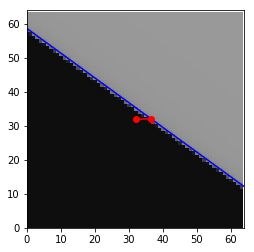

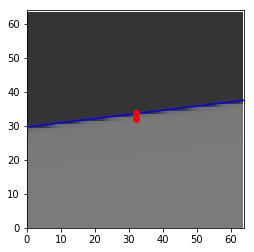

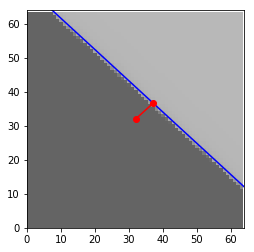

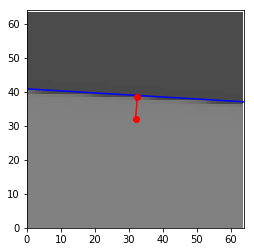

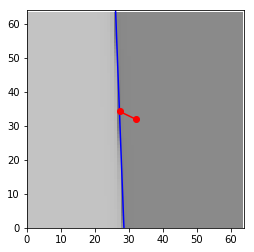

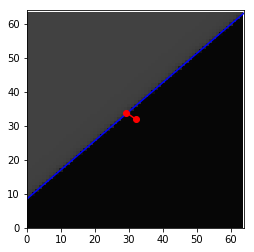

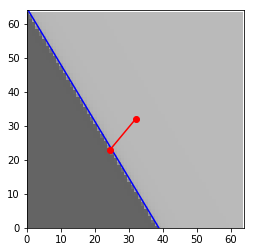

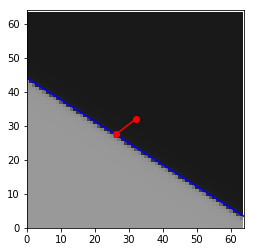

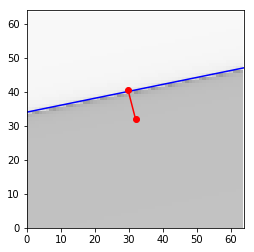

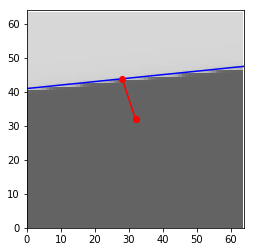

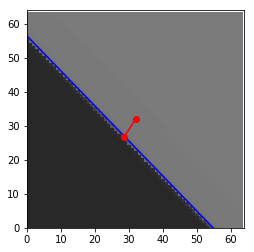

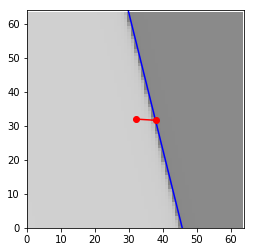

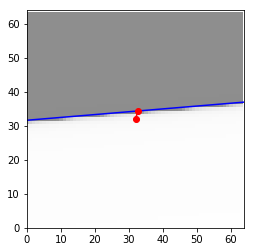

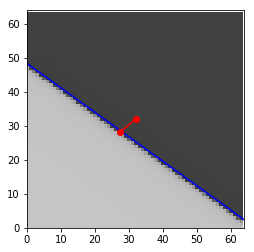

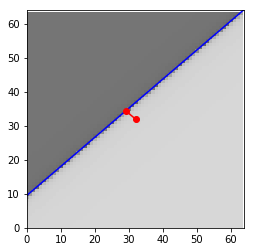

In [61]:
# Plot the Results

# Results are surprisingly good with 13k parameters
# Let's start monitoring generalizability

model.eval();

for batch_i, data in enumerate(test_loader):
    # get the input images and their corresponding labels
    inputs, output_gt, _, _ = data
    inputs, output_gt = inputs.to(dev), output_gt.to(dev)
        
    # forward pass to get outputs
    outputs = model(inputs).squeeze().detach().cpu()
        
    c = -output_gt[:,2]*torch.cos(output_gt[:,0]) + output_gt[:,1]*torch.sin(output_gt[:,0])
    angle_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0]),c),axis=1).detach().cpu()
  
for ii in range(15):
    
    plt.figure()
    plt.imshow(inputs[ii].cpu().squeeze(),cmap='gray', vmin=0, vmax=1)
    
    # Plot the ground truth lines
    x_sample = torch.linspace(-1,1,inputs.shape[-1])
    y_sample = -angle_params[ii,0]/angle_params[ii,1]*x_sample - angle_params[ii,2]/angle_params[ii,1]
    
    plt.plot(x_sample*32+32,y_sample*32+32,'b')
    plt.xlim([0,64])
    plt.ylim(([0,64]))
    
    # Plot the estimated lines
#     y_est = -outputs[ii,0]/outputs[ii,1]*x_sample - outputs[ii,2]/outputs[ii,1]
#     plt.plot(x_sample*32+32,y_est*32+32,'r')

    plot_results = torch.stack((torch.tensor([32,32]),outputs[ii]*32+32),axis=1)
    
    plt.plot(plot_results[0,:],plot_results[1,:],'ro-')




## Try minimum displacement distance

In [62]:
model = displacementNet()
model = model.to(dev)
# model.apply(init_weights)

model.train();

optimizer = torch.optim.Adam(model.parameters(),lr=.001)

n_epochs = 400

mse_loss = nn.MSELoss()
ce_loss = nn.CrossEntropyLoss()

for epoch in range(0,n_epochs):  # loop over the dataset multiple times

    if epoch == 0:
        train_loss_over_time = [] # to track the loss as the network trains
        test_loss_over_time = []
        
    running_loss = 0
    num_batches = 0
    
    for batch_i, data in enumerate(train_loader):
        
        # get the input images and their corresponding labels
        num_batches += 1

        inputs, output_gt, _, _ = data
        inputs, output_gt = inputs.to(dev), output_gt.to(dev)
        
        # zero the parameter (weight) gradients
        optimizer.zero_grad()
        
        # forward pass to get outputs
        output_displacement = torch.cat((model(inputs),torch.ones((len(inputs),1),device=dev)),dim=1)
        
        # make the ground truth
        c = -output_gt[:,2]*torch.cos(output_gt[:,0]) + output_gt[:,1]*torch.sin(output_gt[:,0])
        gt_line_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0]),c),dim=1)
        
        
        # calculate the loss
#         print(output_line_params[:,:,0,50])
#         loss = torch.mean(torch.abs(torch.sum(gt_line_params*output_displacement,1)) + torch.norm(output_displacement,dim=1))
#         loss = mse_loss(output_line_params,gt_line_params)

        w = torch.stack((-gt_line_params[:,0]*gt_line_params[:,2],-gt_line_params[:,1]*gt_line_params[:,2]),dim=1)
    
        loss = torch.mean(torch.abs(torch.sum(gt_line_params*output_displacement,1)) + torch.norm(output_displacement[:,:2]-w,dim=1))


        
        # backward pass to calculate the parameter gradients
        loss.backward()

        # update the parameters
        optimizer.step()

        # to convert loss into a scalar and add it to running_loss, we use .item()
        running_loss += loss.item()
      

    # Calculate test data loss after each epoch
    with torch.no_grad():
        test_loss = 0
        num_batches_test = 0
        for batch_i, data in enumerate(test_loader):
            num_batches_test += 1

            # Add code here
            inputs, output_gt, _, _ = data
            inputs, output_gt = inputs.to(dev), output_gt.to(dev)


            # zero the parameter (weight) gradients
            optimizer.zero_grad()

             # forward pass to get outputs
            output_displacement = torch.cat((model(inputs),torch.ones((len(inputs),1),device=dev)),dim=1)

            # make the ground truth
            c = -output_gt[:,2]*torch.cos(output_gt[:,0]) + output_gt[:,1]*torch.sin(output_gt[:,0])
            gt_line_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0]),c),dim=1)


            # calculate the loss
#             loss = torch.mean(torch.abs(torch.sum(gt_line_params*output_displacement,1)) + torch.norm(output_displacement,dim=1))
            w = torch.stack((-gt_line_params[:,0]*gt_line_params[:,2],-gt_line_params[:,1]*gt_line_params[:,2]),dim=1)
            loss = torch.mean(torch.abs(torch.sum(gt_line_params*output_displacement,1)) + torch.norm(output_displacement[:,:2]-w,dim=1))

            test_loss += loss
                    
        test_loss_over_time.append(test_loss/num_batches_test)


    # Calculate model loss:
    avg_loss = running_loss/num_batches
    train_loss_over_time.append(avg_loss)
    
#     print('Epoch: {}, Avg. Train Loss: {},'.format(epoch + 1, train_loss_over_time[-1]))


    print('Epoch: {}, Avg. Train Loss: {}, Avg. Test Loss: {}'.format(epoch + 1, train_loss_over_time[-1], test_loss_over_time[-1]))
    
print('Finished Training')

Epoch: 1, Avg. Train Loss: 0.3264123469591141, Avg. Test Loss: 0.19439361989498138
Epoch: 2, Avg. Train Loss: 0.14206903769689447, Avg. Test Loss: 0.12109337747097015
Epoch: 3, Avg. Train Loss: 0.11240740225595587, Avg. Test Loss: 0.11991013586521149
Epoch: 4, Avg. Train Loss: 0.09374420336064171, Avg. Test Loss: 0.10546115040779114
Epoch: 5, Avg. Train Loss: 0.07752322208355455, Avg. Test Loss: 0.07996685802936554
Epoch: 6, Avg. Train Loss: 0.07250129869755577, Avg. Test Loss: 0.064332515001297
Epoch: 7, Avg. Train Loss: 0.056649644366082025, Avg. Test Loss: 0.05016060173511505
Epoch: 8, Avg. Train Loss: 0.05003043380292023, Avg. Test Loss: 0.05978279933333397
Epoch: 9, Avg. Train Loss: 0.05755307411446291, Avg. Test Loss: 0.05048704892396927
Epoch: 10, Avg. Train Loss: 0.04142351426622447, Avg. Test Loss: 0.04100603982806206
Epoch: 11, Avg. Train Loss: 0.05508681347264963, Avg. Test Loss: 0.04584338143467903
Epoch: 12, Avg. Train Loss: 0.040207274521098416, Avg. Test Loss: 0.03745331

Epoch: 97, Avg. Train Loss: 0.01914077092181234, Avg. Test Loss: 0.020764553919434547
Epoch: 98, Avg. Train Loss: 0.020756806805729867, Avg. Test Loss: 0.021589651703834534
Epoch: 99, Avg. Train Loss: 0.019987518603310866, Avg. Test Loss: 0.021087534725666046
Epoch: 100, Avg. Train Loss: 0.024988759374793838, Avg. Test Loss: 0.019704727455973625
Epoch: 101, Avg. Train Loss: 0.018909297500024822, Avg. Test Loss: 0.01880517043173313
Epoch: 102, Avg. Train Loss: 0.021220951625967727, Avg. Test Loss: 0.02270832099020481
Epoch: 103, Avg. Train Loss: 0.020319963147973314, Avg. Test Loss: 0.019856596365571022
Epoch: 104, Avg. Train Loss: 0.021072228088536683, Avg. Test Loss: 0.019272010773420334
Epoch: 105, Avg. Train Loss: 0.020088298947495573, Avg. Test Loss: 0.019975828006863594
Epoch: 106, Avg. Train Loss: 0.01925725669545286, Avg. Test Loss: 0.019255833700299263
Epoch: 107, Avg. Train Loss: 0.020296332755071277, Avg. Test Loss: 0.019382627680897713
Epoch: 108, Avg. Train Loss: 0.02012652

Epoch: 191, Avg. Train Loss: 0.01595028572003631, Avg. Test Loss: 0.01694018393754959
Epoch: 192, Avg. Train Loss: 0.0168822968049961, Avg. Test Loss: 0.017360744997859
Epoch: 193, Avg. Train Loss: 0.01704774743274731, Avg. Test Loss: 0.01595223881304264
Epoch: 194, Avg. Train Loss: 0.016018432082937045, Avg. Test Loss: 0.016426028683781624
Epoch: 195, Avg. Train Loss: 0.016594329312005465, Avg. Test Loss: 0.015648458153009415
Epoch: 196, Avg. Train Loss: 0.016570132883156046, Avg. Test Loss: 0.015685180202126503
Epoch: 197, Avg. Train Loss: 0.016143050833660015, Avg. Test Loss: 0.015974579378962517
Epoch: 198, Avg. Train Loss: 0.01678783438880654, Avg. Test Loss: 0.017771858721971512
Epoch: 199, Avg. Train Loss: 0.016482599682229405, Avg. Test Loss: 0.016801750287413597
Epoch: 200, Avg. Train Loss: 0.01631263827576357, Avg. Test Loss: 0.016515890136361122
Epoch: 201, Avg. Train Loss: 0.016681041437036852, Avg. Test Loss: 0.017290500923991203
Epoch: 202, Avg. Train Loss: 0.016431087880

Epoch: 285, Avg. Train Loss: 0.014085067841498291, Avg. Test Loss: 0.01536665577441454
Epoch: 286, Avg. Train Loss: 0.01398722847156665, Avg. Test Loss: 0.01495515089482069
Epoch: 287, Avg. Train Loss: 0.01440174193943248, Avg. Test Loss: 0.013819387182593346
Epoch: 288, Avg. Train Loss: 0.013638594067272018, Avg. Test Loss: 0.014860155060887337
Epoch: 289, Avg. Train Loss: 0.014492190804551629, Avg. Test Loss: 0.014558842405676842
Epoch: 290, Avg. Train Loss: 0.015478070452809333, Avg. Test Loss: 0.014941303059458733
Epoch: 291, Avg. Train Loss: 0.01374527738593957, Avg. Test Loss: 0.014225308783352375
Epoch: 292, Avg. Train Loss: 0.014434084723539213, Avg. Test Loss: 0.013823642395436764
Epoch: 293, Avg. Train Loss: 0.014111034254379132, Avg. Test Loss: 0.013959513045847416
Epoch: 294, Avg. Train Loss: 0.013750232076820206, Avg. Test Loss: 0.014035164378583431
Epoch: 295, Avg. Train Loss: 0.014681517617667422, Avg. Test Loss: 0.016458863392472267
Epoch: 296, Avg. Train Loss: 0.013298

Epoch: 379, Avg. Train Loss: 0.011821766964652959, Avg. Test Loss: 0.016167499125003815
Epoch: 380, Avg. Train Loss: 0.013270858565674108, Avg. Test Loss: 0.01630168780684471
Epoch: 381, Avg. Train Loss: 0.012854926540132832, Avg. Test Loss: 0.013976596295833588
Epoch: 382, Avg. Train Loss: 0.012228500076076563, Avg. Test Loss: 0.013609016314148903
Epoch: 383, Avg. Train Loss: 0.012796584242845284, Avg. Test Loss: 0.014825875870883465
Epoch: 384, Avg. Train Loss: 0.012768911077257465, Avg. Test Loss: 0.013844533823430538
Epoch: 385, Avg. Train Loss: 0.014612771351547801, Avg. Test Loss: 0.017185725271701813
Epoch: 386, Avg. Train Loss: 0.012220265519093065, Avg. Test Loss: 0.014732930809259415
Epoch: 387, Avg. Train Loss: 0.013214889059171958, Avg. Test Loss: 0.012147362343966961
Epoch: 388, Avg. Train Loss: 0.01430129972012604, Avg. Test Loss: 0.012745515443384647
Epoch: 389, Avg. Train Loss: 0.013448596975820907, Avg. Test Loss: 0.013166265562176704
Epoch: 390, Avg. Train Loss: 0.013

tensor(0.0059)
tensor(0.0057)
tensor(0.0052)
tensor(0.0056)
tensor(0.0041)
tensor(0.0058)
tensor(0.0066)
tensor(0.0066)
tensor(0.0045)
tensor(0.0063)
tensor(0.0055)
tensor(0.0060)
tensor(0.0074)
tensor(0.0050)
tensor(0.0051)


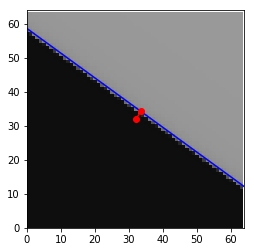

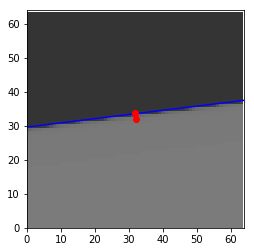

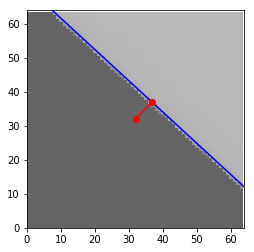

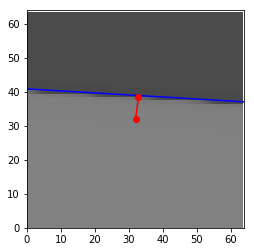

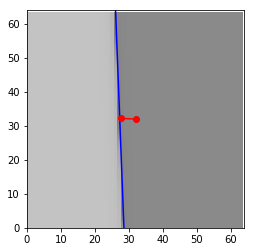

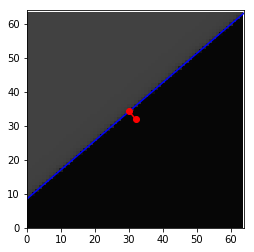

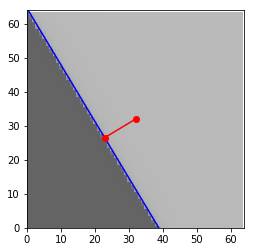

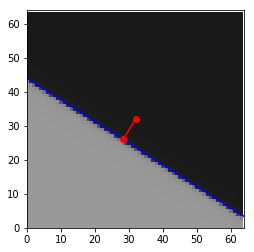

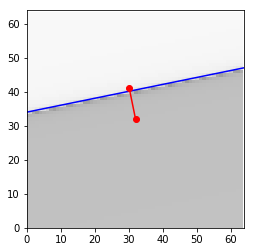

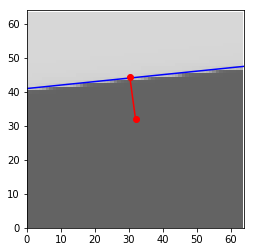

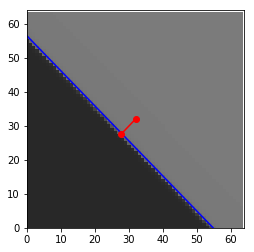

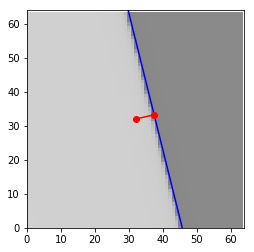

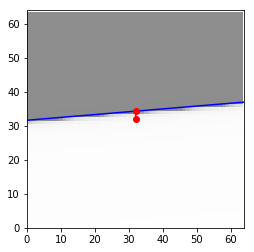

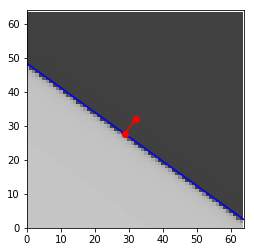

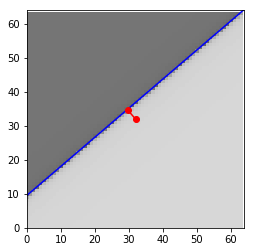

In [63]:
# Plot the Results

# Results are surprisingly good with 13k parameters
# Let's start monitoring generalizability

model.eval();

for batch_i, data in enumerate(test_loader):
    # get the input images and their corresponding labels
    inputs, output_gt, _, _ = data
    inputs, output_gt = inputs.to(dev), output_gt.to(dev)
        
    # forward pass to get outputs
    outputs = model(inputs).squeeze().detach().cpu()
        
    c = -output_gt[:,2]*torch.cos(output_gt[:,0]) + output_gt[:,1]*torch.sin(output_gt[:,0])
    angle_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0]),c),axis=1).detach().cpu()
    
    output_displacement = torch.cat((outputs,torch.ones((len(inputs),1))),dim=1) 
    # Calculate the loss for previous metric
    loss = torch.mean(torch.abs(torch.sum(angle_params*output_displacement,1))) 
    
    print(loss)

    
  
for ii in range(15):
    
    plt.figure()
    plt.imshow(inputs[ii].cpu().squeeze(),cmap='gray', vmin=0, vmax=1)
    
    # Plot the ground truth lines
    x_sample = torch.linspace(-1,1,inputs.shape[-1])
    y_sample = -angle_params[ii,0]/angle_params[ii,1]*x_sample - angle_params[ii,2]/angle_params[ii,1]
    
    plt.plot(x_sample*32+32,y_sample*32+32,'b')
    plt.xlim([0,64])
    plt.ylim(([0,64]))
    
    # Plot the estimated lines
#     y_est = -outputs[ii,0]/outputs[ii,1]*x_sample - outputs[ii,2]/outputs[ii,1]
#     plt.plot(x_sample*32+32,y_est*32+32,'r')

    plot_results = torch.stack((torch.tensor([32,32]),outputs[ii]*32+32),axis=1)
    
    plt.plot(plot_results[0,:],plot_results[1,:],'ro-')





## Testing without max pooling

In [64]:
class displacementNet(nn.Module):

    def __init__(self):
        super().__init__()
                
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3)
        self.fc = nn.LazyLinear(2)
        self.maxpool = nn.MaxPool2d(2)
    
    def forward(self, x):

        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
#         x = self.conv3(x)
#         x = F.relu(self.maxpool(x))
#         x = self.conv4(x)
#         x = F.relu(self.maxpool(x))
        x = x.view(x.shape[0],-1)
        x = self.fc(x)
        
        # We're defining
        # a = - sin(theta)
        # b = cos(theta)
        # c = -cy*cos(theta)+cx*sin(theta)
        # Hence, we want to normalize the vector by 1/sqrt(a^2 + b^2)
#         norm_factor = (torch.norm(x[:,:2],p=2,dim=1)).unsqueeze(1)        
#         out = x/(norm_factor)#+eps)
#         print('Output shape=',x.shape)

        out = x
        
        return out
    
model = displacementNet()
model = model.to(dev)
summary(model, input_size=[(1, 64, 64)])

model.train();

optimizer = torch.optim.Adam(model.parameters(),lr=.001)

n_epochs = 400

mse_loss = nn.MSELoss()
ce_loss = nn.CrossEntropyLoss()

for epoch in range(0,n_epochs):  # loop over the dataset multiple times

    if epoch == 0:
        train_loss_over_time = [] # to track the loss as the network trains
        test_loss_over_time = []
        
    running_loss = 0
    num_batches = 0
    
    for batch_i, data in enumerate(train_loader):
        
        # get the input images and their corresponding labels
        num_batches += 1

        inputs, output_gt, _, _ = data
        inputs, output_gt = inputs.to(dev), output_gt.to(dev)
        
        # zero the parameter (weight) gradients
        optimizer.zero_grad()
        
        # forward pass to get outputs
        output_displacement = torch.cat((model(inputs),torch.ones((len(inputs),1),device=dev)),dim=1)
        
        # make the ground truth
        c = -output_gt[:,2]*torch.cos(output_gt[:,0]) + output_gt[:,1]*torch.sin(output_gt[:,0])
        gt_line_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0]),c),dim=1)
        
        
        # calculate the loss
#         print(output_line_params[:,:,0,50])
#         loss = torch.mean(torch.abs(torch.sum(gt_line_params*output_displacement,1)) + torch.norm(output_displacement,dim=1))
#         loss = mse_loss(output_line_params,gt_line_params)

        w = torch.stack((-gt_line_params[:,0]*gt_line_params[:,2],-gt_line_params[:,1]*gt_line_params[:,2]),dim=1)
    
        loss = torch.mean(torch.abs(torch.sum(gt_line_params*output_displacement,1)) + torch.norm(output_displacement[:,:2]-w,dim=1))


        
        # backward pass to calculate the parameter gradients
        loss.backward()

        # update the parameters
        optimizer.step()

        # to convert loss into a scalar and add it to running_loss, we use .item()
        running_loss += loss.item()
      

    # Calculate test data loss after each epoch
    with torch.no_grad():
        test_loss = 0
        num_batches_test = 0
        for batch_i, data in enumerate(test_loader):
            num_batches_test += 1

            # Add code here
            inputs, output_gt, _, _ = data
            inputs, output_gt = inputs.to(dev), output_gt.to(dev)


            # zero the parameter (weight) gradients
            optimizer.zero_grad()

             # forward pass to get outputs
            output_displacement = torch.cat((model(inputs),torch.ones((len(inputs),1),device=dev)),dim=1)

            # make the ground truth
            c = -output_gt[:,2]*torch.cos(output_gt[:,0]) + output_gt[:,1]*torch.sin(output_gt[:,0])
            gt_line_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0]),c),dim=1)


            # calculate the loss
#             loss = torch.mean(torch.abs(torch.sum(gt_line_params*output_displacement,1)) + torch.norm(output_displacement,dim=1))
            w = torch.stack((-gt_line_params[:,0]*gt_line_params[:,2],-gt_line_params[:,1]*gt_line_params[:,2]),dim=1)
            loss = torch.mean(torch.abs(torch.sum(gt_line_params*output_displacement,1)) + torch.norm(output_displacement[:,:2]-w,dim=1))

            test_loss += loss
                    
        test_loss_over_time.append(test_loss/num_batches_test)


    # Calculate model loss:
    avg_loss = running_loss/num_batches
    train_loss_over_time.append(avg_loss)
    
#     print('Epoch: {}, Avg. Train Loss: {},'.format(epoch + 1, train_loss_over_time[-1]))


    print('Epoch: {}, Avg. Train Loss: {}, Avg. Test Loss: {}'.format(epoch + 1, train_loss_over_time[-1], test_loss_over_time[-1]))
    
print('Finished Training')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 62, 62]             640
            Conv2d-2           [-1, 64, 60, 60]          36,928
            Linear-3                    [-1, 2]         460,802
Total params: 498,370
Trainable params: 498,370
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/backward pass size (MB): 3.63
Params size (MB): 1.90
Estimated Total Size (MB): 5.55
----------------------------------------------------------------
Epoch: 1, Avg. Train Loss: 0.7768876198460074, Avg. Test Loss: 0.33319365978240967
Epoch: 2, Avg. Train Loss: 0.3071158966597389, Avg. Test Loss: 0.2889553904533386
Epoch: 3, Avg. Train Loss: 0.3040668065057081, Avg. Test Loss: 0.31985577940940857
Epoch: 4, Avg. Train Loss: 0.26091445824679205, Avg. Test Loss: 0.3109142780303955
Epoch: 5, Avg. Train Loss: 0.25

Epoch: 89, Avg. Train Loss: 0.03167495940099744, Avg. Test Loss: 0.0445624515414238
Epoch: 90, Avg. Train Loss: 0.030816821052747613, Avg. Test Loss: 0.04147322103381157
Epoch: 91, Avg. Train Loss: 0.0314385116319446, Avg. Test Loss: 0.04196666181087494
Epoch: 92, Avg. Train Loss: 0.02983295117669246, Avg. Test Loss: 0.040666162967681885
Epoch: 93, Avg. Train Loss: 0.030606201992315403, Avg. Test Loss: 0.04011479765176773
Epoch: 94, Avg. Train Loss: 0.03251540371600319, Avg. Test Loss: 0.04002334177494049
Epoch: 95, Avg. Train Loss: 0.031041530826512505, Avg. Test Loss: 0.03945232182741165
Epoch: 96, Avg. Train Loss: 0.028557672548819992, Avg. Test Loss: 0.0402376689016819
Epoch: 97, Avg. Train Loss: 0.028454760527786088, Avg. Test Loss: 0.038552653044462204
Epoch: 98, Avg. Train Loss: 0.02729315648184103, Avg. Test Loss: 0.038503099232912064
Epoch: 99, Avg. Train Loss: 0.0287159575478119, Avg. Test Loss: 0.03747863322496414
Epoch: 100, Avg. Train Loss: 0.03332001262289636, Avg. Test L

Epoch: 184, Avg. Train Loss: 0.018172548919477883, Avg. Test Loss: 0.02425031177699566
Epoch: 185, Avg. Train Loss: 0.01654255634502453, Avg. Test Loss: 0.02221744880080223
Epoch: 186, Avg. Train Loss: 0.01735481027075473, Avg. Test Loss: 0.02294052764773369
Epoch: 187, Avg. Train Loss: 0.01647053641431472, Avg. Test Loss: 0.02178698405623436
Epoch: 188, Avg. Train Loss: 0.016878774225273552, Avg. Test Loss: 0.02043270505964756
Epoch: 189, Avg. Train Loss: 0.022111143215614207, Avg. Test Loss: 0.042946312576532364
Epoch: 190, Avg. Train Loss: 0.021399976225460277, Avg. Test Loss: 0.023843176662921906
Epoch: 191, Avg. Train Loss: 0.018710376913933194, Avg. Test Loss: 0.022528572008013725
Epoch: 192, Avg. Train Loss: 0.018488887040054098, Avg. Test Loss: 0.021198758855462074
Epoch: 193, Avg. Train Loss: 0.0186371555990156, Avg. Test Loss: 0.020917251706123352
Epoch: 194, Avg. Train Loss: 0.0174145096584278, Avg. Test Loss: 0.021135739982128143
Epoch: 195, Avg. Train Loss: 0.0159831664251

Epoch: 278, Avg. Train Loss: 0.013167544114677346, Avg. Test Loss: 0.01710548810660839
Epoch: 279, Avg. Train Loss: 0.013889256426516701, Avg. Test Loss: 0.016427157446742058
Epoch: 280, Avg. Train Loss: 0.019659796883078184, Avg. Test Loss: 0.029218798503279686
Epoch: 281, Avg. Train Loss: 0.019436683768735214, Avg. Test Loss: 0.01812581717967987
Epoch: 282, Avg. Train Loss: 0.015921532362699508, Avg. Test Loss: 0.01757931523025036
Epoch: 283, Avg. Train Loss: 0.014220141761881463, Avg. Test Loss: 0.016995443031191826
Epoch: 284, Avg. Train Loss: 0.014171979302430854, Avg. Test Loss: 0.01781863532960415
Epoch: 285, Avg. Train Loss: 0.018397361653692584, Avg. Test Loss: 0.02347490005195141
Epoch: 286, Avg. Train Loss: 0.016244986445149955, Avg. Test Loss: 0.02180476486682892
Epoch: 287, Avg. Train Loss: 0.01708791197880226, Avg. Test Loss: 0.01860034093260765
Epoch: 288, Avg. Train Loss: 0.017748350036494873, Avg. Test Loss: 0.018078938126564026
Epoch: 289, Avg. Train Loss: 0.013388156

Epoch: 372, Avg. Train Loss: 0.014279076007797438, Avg. Test Loss: 0.017568644136190414
Epoch: 373, Avg. Train Loss: 0.012955098095185616, Avg. Test Loss: 0.0167536661028862
Epoch: 374, Avg. Train Loss: 0.01273743343703887, Avg. Test Loss: 0.016534384340047836
Epoch: 375, Avg. Train Loss: 0.01320487608147018, Avg. Test Loss: 0.01679142937064171
Epoch: 376, Avg. Train Loss: 0.013722065145916798, Avg. Test Loss: 0.015077986754477024
Epoch: 377, Avg. Train Loss: 0.014106363737407852, Avg. Test Loss: 0.020059634000062943
Epoch: 378, Avg. Train Loss: 0.013072944092838204, Avg. Test Loss: 0.017302440479397774
Epoch: 379, Avg. Train Loss: 0.017235769013709882, Avg. Test Loss: 0.0315263532102108
Epoch: 380, Avg. Train Loss: 0.019776047108804477, Avg. Test Loss: 0.01713702641427517
Epoch: 381, Avg. Train Loss: 0.014726091680281302, Avg. Test Loss: 0.01732722669839859
Epoch: 382, Avg. Train Loss: 0.013345179115148152, Avg. Test Loss: 0.01588217169046402
Epoch: 383, Avg. Train Loss: 0.01378919026

tensor(0.0064)
tensor(0.0071)
tensor(0.0075)
tensor(0.0076)
tensor(0.0070)
tensor(0.0078)
tensor(0.0074)
tensor(0.0086)
tensor(0.0077)
tensor(0.0071)
tensor(0.0072)
tensor(0.0073)
tensor(0.0085)
tensor(0.0070)
tensor(0.0074)


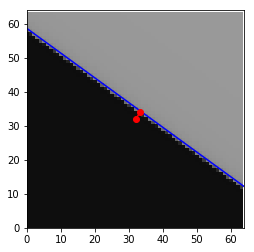

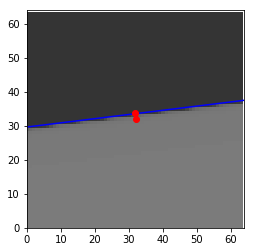

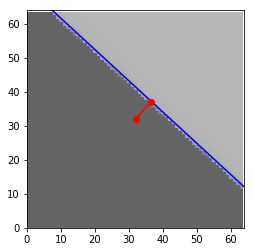

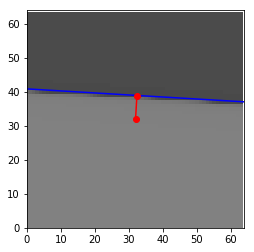

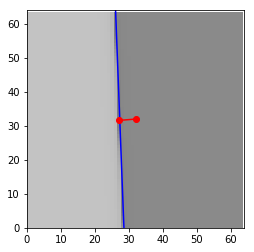

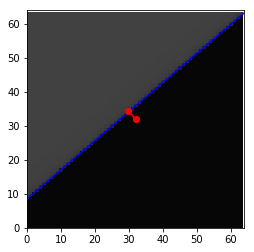

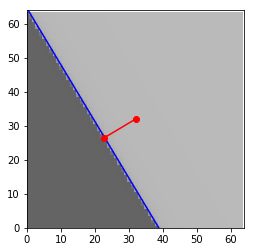

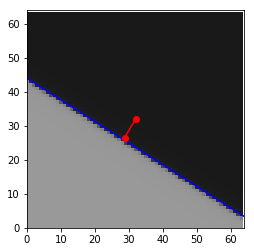

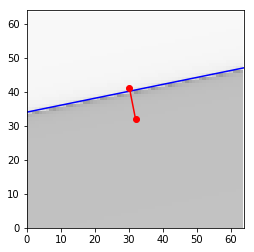

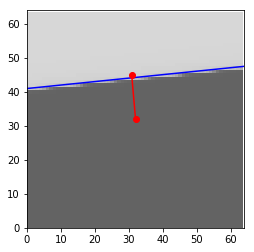

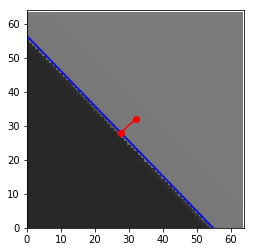

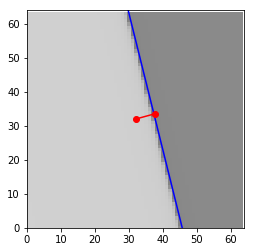

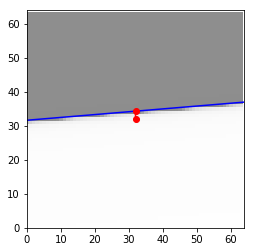

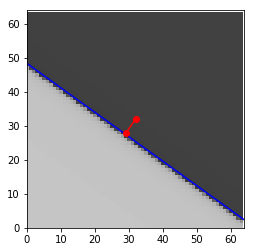

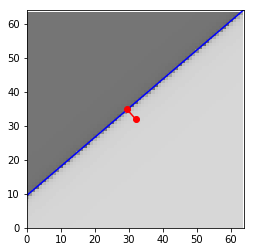

In [65]:
# Plot the Results

# Results are surprisingly good with 13k parameters
# Let's start monitoring generalizability

model.eval();

for batch_i, data in enumerate(test_loader):
    # get the input images and their corresponding labels
    inputs, output_gt, _, _ = data
    inputs, output_gt = inputs.to(dev), output_gt.to(dev)
        
    # forward pass to get outputs
    outputs = model(inputs).squeeze().detach().cpu()
        
    c = -output_gt[:,2]*torch.cos(output_gt[:,0]) + output_gt[:,1]*torch.sin(output_gt[:,0])
    angle_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0]),c),axis=1).detach().cpu()
    
    output_displacement = torch.cat((outputs,torch.ones((len(inputs),1))),dim=1) 
    # Calculate the loss for previous metric
    loss = torch.mean(torch.abs(torch.sum(angle_params*output_displacement,1))) 
    
    print(loss)

    
  
for ii in range(15):
    
    plt.figure()
    plt.imshow(inputs[ii].cpu().squeeze(),cmap='gray', vmin=0, vmax=1)
    
    # Plot the ground truth lines
    x_sample = torch.linspace(-1,1,inputs.shape[-1])
    y_sample = -angle_params[ii,0]/angle_params[ii,1]*x_sample - angle_params[ii,2]/angle_params[ii,1]
    
    plt.plot(x_sample*32+32,y_sample*32+32,'b')
    plt.xlim([0,64])
    plt.ylim(([0,64]))
    
    # Plot the estimated lines
#     y_est = -outputs[ii,0]/outputs[ii,1]*x_sample - outputs[ii,2]/outputs[ii,1]
#     plt.plot(x_sample*32+32,y_est*32+32,'r')

    plot_results = torch.stack((torch.tensor([32,32]),outputs[ii]*32+32),axis=1)
    
    plt.plot(plot_results[0,:],plot_results[1,:],'ro-')






In [ ]:
class displacementNet(nn.Module):

    def __init__(self):
        super().__init__()
                
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3)
        self.fc = nn.LazyLinear(2)
        self.maxpool = nn.MaxPool2d(2)
    
    def forward(self, x):

        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
#         x = self.conv3(x)
#         x = F.relu(self.maxpool(x))
#         x = self.conv4(x)
#         x = F.relu(self.maxpool(x))
        x = x.view(x.shape[0],-1)
        x = self.fc(x)
        
        # We're defining
        # a = - sin(theta)
        # b = cos(theta)
        # c = -cy*cos(theta)+cx*sin(theta)
        # Hence, we want to normalize the vector by 1/sqrt(a^2 + b^2)
#         norm_factor = (torch.norm(x[:,:2],p=2,dim=1)).unsqueeze(1)        
#         out = x/(norm_factor)#+eps)
#         print('Output shape=',x.shape)

        out = x
        
        return out
    
model = displacementNet()
model = model.to(dev)
summary(model, input_size=[(1, 64, 64)])

model.train();

optimizer = torch.optim.Adam(model.parameters(),lr=.001)

n_epochs = 400

mse_loss = nn.MSELoss()
ce_loss = nn.CrossEntropyLoss()

for epoch in range(0,n_epochs):  # loop over the dataset multiple times

    if epoch == 0:
        train_loss_over_time = [] # to track the loss as the network trains
        test_loss_over_time = []
        
    running_loss = 0
    num_batches = 0
    
    for batch_i, data in enumerate(train_loader):
        
        # get the input images and their corresponding labels
        num_batches += 1

        inputs, output_gt, _, _ = data
        inputs, output_gt = inputs.to(dev), output_gt.to(dev)
        
        # zero the parameter (weight) gradients
        optimizer.zero_grad()
        
        # forward pass to get outputs
        output_displacement = torch.cat((model(inputs),torch.ones((len(inputs),1),device=dev)),dim=1)
        
        # make the ground truth
        c = -output_gt[:,2]*torch.cos(output_gt[:,0]) + output_gt[:,1]*torch.sin(output_gt[:,0])
        gt_line_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0]),c),dim=1)
        
        
        # calculate the loss
#         print(output_line_params[:,:,0,50])
#         loss = torch.mean(torch.abs(torch.sum(gt_line_params*output_displacement,1)) + torch.norm(output_displacement,dim=1))
#         loss = mse_loss(output_line_params,gt_line_params)

        w = torch.stack((-gt_line_params[:,0]*gt_line_params[:,2],-gt_line_params[:,1]*gt_line_params[:,2]),dim=1)
    
        loss = torch.mean(torch.abs(torch.sum(gt_line_params*output_displacement,1)) + torch.norm(output_displacement[:,:2]-w,dim=1))


        
        # backward pass to calculate the parameter gradients
        loss.backward()

        # update the parameters
        optimizer.step()

        # to convert loss into a scalar and add it to running_loss, we use .item()
        running_loss += loss.item()
      

    # Calculate test data loss after each epoch
    with torch.no_grad():
        test_loss = 0
        num_batches_test = 0
        for batch_i, data in enumerate(test_loader):
            num_batches_test += 1

            # Add code here
            inputs, output_gt, _, _ = data
            inputs, output_gt = inputs.to(dev), output_gt.to(dev)


            # zero the parameter (weight) gradients
            optimizer.zero_grad()

             # forward pass to get outputs
            output_displacement = torch.cat((model(inputs),torch.ones((len(inputs),1),device=dev)),dim=1)

            # make the ground truth
            c = -output_gt[:,2]*torch.cos(output_gt[:,0]) + output_gt[:,1]*torch.sin(output_gt[:,0])
            gt_line_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0]),c),dim=1)


            # calculate the loss
#             loss = torch.mean(torch.abs(torch.sum(gt_line_params*output_displacement,1)) + torch.norm(output_displacement,dim=1))
            w = torch.stack((-gt_line_params[:,0]*gt_line_params[:,2],-gt_line_params[:,1]*gt_line_params[:,2]),dim=1)
            loss = torch.mean(torch.abs(torch.sum(gt_line_params*output_displacement,1)) + torch.norm(output_displacement[:,:2]-w,dim=1))

            test_loss += loss
                    
        test_loss_over_time.append(test_loss/num_batches_test)


    # Calculate model loss:
    avg_loss = running_loss/num_batches
    train_loss_over_time.append(avg_loss)
    
#     print('Epoch: {}, Avg. Train Loss: {},'.format(epoch + 1, train_loss_over_time[-1]))


    print('Epoch: {}, Avg. Train Loss: {}, Avg. Test Loss: {}'.format(epoch + 1, train_loss_over_time[-1], test_loss_over_time[-1]))
    
print('Finished Training')